# Specular Model Tester: Present (Comparison Method)

## For when you want to show it to other people

### The actual model tester code notebook is a hodgepodge mess of all sorts of random nonsense...

This notebook is meant to showcase the Specular Model for Titan, comparing it to real data and thus validating it. 

Notably it has not successfully been validated yet, but we've learned a lot so far. 

Anyway, let's just load the files and imports we need, then let's talk about them.

In [1]:
#IMPORTS 
import csv
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.misc
from scipy import ndimage
from pyvims import VIMS
import statistics
from matplotlib.colors import LogNorm
import matplotlib.animation as animation

#READ IN CUBE OF INTEREST (what are we comparing to?)
#READ-IN
usePyVIMS = False #Set to False to use cubeFilePath for a local file.
#Yes this was added to the code later so it is an absolute patchwork mess of a job. 
#NOTE: local files are MUCH faster.

#1) The Cube Itself.
cubeFilePath = r"C:\Users\deran\Desktop\CubeCSVDatabase\T104\CM_1787307197_1.cub.csv" #North Pole

cubeFilePath = r"C:\Users\deran\Desktop\CubeCSVDatabase\T24\CM_1548747455_1.cub.csv"

cubeFilePath = r"C:\Users\deran\Desktop\CubeCSVDatabase\T104\CM_1787307197_1.cub.csv" 
#Here twice since I'm not saving everything. ...Man this entire notebook is a crime against neat code...

realCube = "1767300222_1"
cube = VIMS(realCube) #To avoid unecessary reading of data, comment this out when not using PyVIMS.
#Yes, I am lazy, why do you ask?

mod=1. #Set here since multiple blocks will want to use it.
#We divide by this number, so larger numbers dim the image. 1 is default.
cubeNum = ""
flybyNum = ""

#Extract the flyby and cube numbers.
if (usePyVIMS == False):
    cubeNum = cubeFilePath.removesuffix(r".cub.csv")
    cubeNum = cubeNum.removeprefix(r"C:\Users\deran\Desktop\CubeCSVDatabase")
    flybyNum = cubeNum[1:5]
    flybyNum = flybyNum.replace("\\","")
    flybyNum = flybyNum.replace("C","")
    cubeNum = cubeNum[-15:]
else: 
    cubeNum = realCube
    flybyNum = cube.flyby
print(flybyNum)
print(cubeNum)

#Now we extract the axes file as well...
cubeAxesfp = cubeFilePath.removesuffix(".csv") + ".axes.csv"

#and THIS time we also need the geofile! We only need the IR one, but we should read the others in just in case.

cubeGeofpVIS = cubeFilePath.removesuffix(".cub.csv") + "_ir_geo.cub.csv"
cubeGeofpIR = cubeFilePath.removesuffix(".cub.csv") + "_vis_geo.cub.csv"
cubeGeofpVISaxes = cubeFilePath.removesuffix(".cub.csv") + "_ir_geo.cub.axes.csv"
cubeGeofpIRaxes = cubeFilePath.removesuffix(".cub.csv") + "_vis_geo.cub.axes.csv"

#Load all the axes in. 
xAxisCube = []
yAxisCube = []
zAxisCube = []

xAxisGeoIR = []
yAxisGeoIR = []
zAxisGeoIR = []

xAxisGeoVIS = []
yAxisGeoVIS = []
zAxisGeoVIS = []
if (usePyVIMS == False):
    with open(cubeAxesfp) as csv_file: #remember to tab.
            csv_reader = csv.reader(csv_file, delimiter=',')
            line_count = 0
            for row in csv_reader:
                i = 0
                L = len(row)
                while (i < L-1):
                    if (line_count == 0):
                        xAxisCube.append(row[i])
                    elif (line_count == 1):
                        yAxisCube.append(row[i])
                    elif (line_count == 2):
                        zAxisCube.append(row[i])
                    i = i+1
                line_count += 1
    with open(cubeGeofpVISaxes) as csv_file: #remember to tab.
            csv_reader = csv.reader(csv_file, delimiter=',')
            line_count = 0
            for row in csv_reader:
                i = 0
                L = len(row)
                while (i < L-1):
                    if (line_count == 0):
                        xAxisGeoVIS.append(row[i])
                    elif (line_count == 1):
                        yAxisGeoVIS.append(row[i])
                    elif (line_count == 2):
                        zAxisGeoVIS.append(row[i])
                    i = i+1
                line_count += 1
    with open(cubeGeofpIRaxes) as csv_file: #remember to tab.
            csv_reader = csv.reader(csv_file, delimiter=',')
            line_count = 0
            for row in csv_reader:
                i = 0
                L = len(row)
                while (i < L-1):
                    if (line_count == 0):
                        xAxisGeoIR.append(row[i])
                    elif (line_count == 1):
                        yAxisGeoIR.append(row[i])
                    elif (line_count == 2):
                        zAxisGeoIR.append(row[i])
                    i = i+1
                line_count += 1
else:
    #If we are using PyVIMS, we still need axes to be set, but in a different way.
    i=0
    zAxisGeoIR.append(0) 
    for x in cube.w:
        zAxisCube.append(cube.w[i])
        i = i+1
    i=0
    while (i < cube.shape[1]):
        yAxisCube.append(i)
        yAxisGeoIR.append(i)
        i = i+1
    i=0
    while (i < cube.shape[2]):
        xAxisCube.append(i)
        xAxisGeoIR.append(i)
        i = i+1
    i = 0
    while (i < 8):
        zAxisGeoIR.append(i)
        #No need to do VIS, quite unecessary.
        i = i+1
    
#Now we need to substantiate the data holders for everything. 


cubeData = [[[0 for x in range(len(zAxisCube))] for x in range(len(yAxisCube))] for x in range(len(xAxisCube))]
#geoVISData = [[[0 for x in range(len(zAxisGeoVIS))] for x in range(len(yAxisGeoVIS))] for x in range(len(xAxisGeoVIS))]
geoIRData = [[[0 for x in range(len(zAxisGeoIR))] for x in range(len(yAxisGeoIR))] for x in range(len(xAxisGeoIR))]

#The above holds the data of the cube itself. 

if (usePyVIMS == False):
    with open(cubeFilePath) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        i, j, k = 0, 0, 0
        for row in csv_reader:
            while (i < len(xAxisCube)):
                cubeData[i][j][k] = float(row[i])
                if (math.isnan(cubeData[i][j][k])):
                    cubeData[i][j][k] = 0 #We set nans to zero to allow plotting to take place, careful!
                elif (cubeData[i][j][k] < 0):
                    cubeData[i][j][k] = 0 #Negative values are nonsense.
                elif (cubeData[i][j][k] > 1):
                    cubeData[i][j][k] = 1 #Make saturation obvious? Keep it from overloading. 
                i = i + 1
            i = 0
            j = j + 1
            if (j >= len(yAxisCube)):
                j = 0
                k = k + 1
            line_count += 1
    #with open(cubeGeofpVIS) as csv_file:
    #    csv_reader = csv.reader(csv_file, delimiter=',')
    #    line_count = 0
    #    i, j, k = 0, 0, 0
    #    for row in csv_reader:
    #        while (i < len(xAxisGeoVIS)):
    #            geoVISData[i][j][k] = float(row[i])
    #            if (math.isnan(geoVISData[i][j][k])):
    #                geoVISData[i][j][k] = 0 #We set nans to zero to allow plotting to take place, careful!
    #            i = i + 1
    #        i = 0
    #        j = j + 1
    #        if (j >= len(yAxisGeoVIS)):
    #            j = 0
    #            k = k + 1
    #        line_count += 1
    with open(cubeGeofpIR) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        i, j, k = 0, 0, 0
        for row in csv_reader:
            while (i < len(xAxisGeoIR)):
                geoIRData[i][j][k] = float(row[i])
                if (math.isnan(geoIRData[i][j][k])):
                    geoIRData[i][j][k] = 0 #We set nans to zero to allow plotting to take place, careful!
                elif (geoIRData[i][j][k] < -1000):
                    geoIRData[i][j][k] = 0 #The default value is an extremely negative number. Scrub it.
                i = i + 1
            i = 0
            j = j + 1
            if (j >= len(yAxisGeoIR)):
                j = 0
                k = k + 1
            line_count += 1
else:
    #Okay so read in the data from the PyVIMS cube. 
    #The data itself is easy. Unfortunately we also need the GEO data, which is harder.
    #If we want the same code to work every time, we need to get each geo value 
    #to have the same values as a Jcube.
    #Each entry of a Jcube GEO contains the following:
    # 0: LAT, 1: LON, 2: Sample Resolution, 3: Line resolution, 4: Phase, 5: incidence, 
    #6: emission, 7: North Azimuth, 8: Limb Impact Parameter
    #Found in Detectors.c++ part of SRTC++ 
    #Now we don't need all these values, some of them will just be zero. But they all need to be set.
    
    i, j, k = 0,0,0
    while (i < len(zAxisCube)):
        k = 0
        while (k < len(yAxisCube)):
            j = 0
            while (j < len(xAxisCube)):
                #print(i,j,k)
                cubeData[j][k][i] = cube[i+97][k][j] 
                if (i == 0):
                            
                    try:
                        c = round(cube.ground_lat[k][j]) #This should break if it isn't numeric.
                        #In fact this error is what gave us issues later.
                        geoIRData[j][k][0] = cube.ground_lat[k][j]
                    except:
                        #If not a number, zero it. 
                        geoIRData[j][k][0] = 0.
                    
                    try:
                        c = round(cube.ground_lon[k][j]) #This should break if it isn't numeric.
                        #In fact this error is what gave us issues later.
                        geoIRData[j][k][1] = cube.ground_lon[k][j]
                    except:
                        #If not a number, zero it. 
                        geoIRData[j][k][1] = 0.
                    
                    try:
                        c = round(cube.ground_res[k][j]) #This should break if it isn't numeric.
                        #In fact this error is what gave us issues later.
                        geoIRData[j][k][2] = cube.ground_res[k][j]
                    except:
                        #If not a number, zero it. 
                        geoIRData[j][k][2] = 0.
                        
                    geoIRData[j][k][3] = 0.
                    
                    try:
                        c = round(cube.ground_phase[k][j]) #This should break if it isn't numeric.
                        #In fact this error is what gave us issues later.
                        geoIRData[j][k][4] = cube.ground_phase[k][j]
                    except:
                        #If not a number, zero it. 
                        geoIRData[j][k][4] = 0.
                           
                    try:
                        c = round(cube.ground_inc[k][j]) #This should break if it isn't numeric.
                        #In fact this error is what gave us issues later.
                        geoIRData[j][k][5] = cube.ground_inc[k][j]
                    except:
                        #If not a number, zero it. 
                        geoIRData[j][k][5] = 0.

                    try:
                        c = round(cube.ground_eme[k][j]) #This should break if it isn't numeric.
                        #In fact this error is what gave us issues later.
                        geoIRData[j][k][6] = cube.ground_eme[k][j]
                    except:
                        #If not a number, zero it. 
                        geoIRData[j][k][6] = 0.
                            
                    try:
                        c = round(cube.ground_azi[k][j]) #This should break if it isn't numeric.
                        #In fact this error is what gave us issues later.
                        geoIRData[j][k][7] = cube.ground_azi[k][j]
                    except:
                        #If not a number, zero it. 
                        geoIRData[j][k][7] = 0.
                    
                    geoIRData[j][k][8] = 0.
                    
                if (math.isnan(cubeData[j][k][i])):
                    cubeData[j][k][i] = 0 #We set nans to zero to allow plotting to take place, careful!
                elif (cubeData[j][k][i] < 0):
                    cubeData[j][k][i] = 0 #Negative values are nonsense.
                elif (cubeData[j][k][i] > 1):
                    cubeData[j][k][i] = 1 #Make saturation obvious? Keep it from overloading.                 
                j = j+1
            k = k+1
        i = i+1

#READ IN SPECULAR MODEL (and lambertian model as well, it's good for comparison)
#2) Now we have to load in the viewing geometry simulation data
#This is the same no matter what method we're using, as these are always local.

X = 21
Y = 19
Z = 37
#These are hard coded as I know exactly what files these are.

dataWin1 = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
dataWin2 = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
dataWin3 = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
dataWin4 = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
dataWin5 = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
dataWin6 = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
dataWin7 = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
dataWin8 = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)]
dataWinSpecial = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)]
dataWinSpecial1 = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)]
dataWinSpecial2 = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)]

with open('iephi_consolidate_0.93w.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin1[i][j][k] = float(row[i])
            if (math.isnan(dataWin1[i][j][k])):
                dataWin1[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_consolidate_1.08w.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin2[i][j][k] = float(row[i])
            if (math.isnan(dataWin2[i][j][k])):
                dataWin2[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_consolidate_1.27w.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin3[i][j][k] = float(row[i])
            if (math.isnan(dataWin3[i][j][k])):
                dataWin3[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_consolidate_1.59w.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin4[i][j][k] = float(row[i])
            if (math.isnan(dataWin4[i][j][k])):
                dataWin4[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_consolidate_2.01w.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin5[i][j][k] = float(row[i])
            if (math.isnan(dataWin5[i][j][k])):
                dataWin5[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_consolidate_2.69w.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin6[i][j][k] = float(row[i])
            if (math.isnan(dataWin6[i][j][k])):
                dataWin6[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_consolidate_2.79w.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin7[i][j][k] = float(row[i])
            if (math.isnan(dataWin7[i][j][k])):
                dataWin7[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_consolidate_5.00w.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin8[i][j][k] = float(row[i])
            if (math.isnan(dataWin8[i][j][k])):
                dataWin8[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
        
#Now do it again for the Lambertian files. 

dataWin1L = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
dataWin2L = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
dataWin3L = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
dataWin4L = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
dataWin5L = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
dataWin6L = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
dataWin7L = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
dataWin8L = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)]

with open('iephi_consolidate_0.93wL.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin1L[i][j][k] = float(row[i])
            if (math.isnan(dataWin1L[i][j][k])):
                dataWin1L[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_consolidate_1.08wL.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin2L[i][j][k] = float(row[i])
            if (math.isnan(dataWin2L[i][j][k])):
                dataWin2L[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_consolidate_1.27wL.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin3L[i][j][k] = float(row[i])
            if (math.isnan(dataWin3L[i][j][k])):
                dataWin3L[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_consolidate_1.59wL.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin4L[i][j][k] = float(row[i])
            if (math.isnan(dataWin4L[i][j][k])):
                dataWin4L[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_consolidate_2.01wL.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin5L[i][j][k] = float(row[i])
            if (math.isnan(dataWin5L[i][j][k])):
                dataWin5L[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_consolidate_2.69wL.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin6L[i][j][k] = float(row[i])
            if (math.isnan(dataWin6L[i][j][k])):
                dataWin6L[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_consolidate_2.79wL.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin7L[i][j][k] = float(row[i])
            if (math.isnan(dataWin7L[i][j][k])):
                dataWin7L[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_consolidate_5.00wL.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWin8L[i][j][k] = float(row[i])
            if (math.isnan(dataWin8L[i][j][k])):
                dataWin8L[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_phasefunc_2.0.Jcube.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWinSpecial[i][j][k] = float(row[i])
            if (math.isnan(dataWinSpecial[i][j][k])):
                dataWinSpecial[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_phasefunc1_2.0.Jcube.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWinSpecial1[i][j][k] = float(row[i])
            if (math.isnan(dataWinSpecial1[i][j][k])):
                dataWinSpecial1[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1
with open('iephi_phasefunc2_2.0.Jcube.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    i, j, k = 0, 0, 0
    for row in csv_reader:
        while (i < X):
            dataWinSpecial2[i][j][k] = float(row[i])
            if (math.isnan(dataWinSpecial2[i][j][k])):
                dataWinSpecial2[i][j][k] = 0
            i = i + 1
        i = 0
        j = j + 1
        if (j >= Y):
            j = 0
            k = k + 1
        line_count += 1

#BOOKKEEPING: declare where the windows are. 
windowum = [0.933078, 1.08183, 1.27813, 1.59018, 2.01781, 2.69620, 2.79889, 5.00576]
windowInd = [80, 108, 120, 139, 165, 206, 212, 344]
windowIndAlt = [3,12,24,43,69,110,116,248]

if (len(zAxisCube) <= 256):
    windowInd = windowIndAlt


T104
CM_1787307197_1


## Resources

### What did we just load in?

#### And other preliminary stuff.

We just loaded in a few things: various code imports (some of which may not be necessary it's hard to keep track), the Specular Titan Model, the Lambertian Titan Model, and whatever VIMS cube was selected at the top.

The Specular Titan Model and Lambertian Titan Model are very similar and take the same form. They contain viewing gometry information for two types of Titan: the global methane ocean, and the ideal lambertian model. SRTC++ created both of these models. The information is arranged not by location, but by viewing geometry: every 5 degrees of incidence, emission, and azimuth is a "pixel" in this data set. Only the 8 atmospheric windows of Titan were simulated, so the information has eight "copies." Both Specular and Lambertian are formatted in the same way.

The chosen VIMS cube can be whatever, though for our purposes it is probably a cube with a very good view of a lake or sea. 

The ultimate goal is to show that the Specular Model is valid by doing side-by-side comparisons with real VIMS images of the seas. The cube we will be looking at is displayed with the below code block.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.08768839285714286..1.7286991071428572].


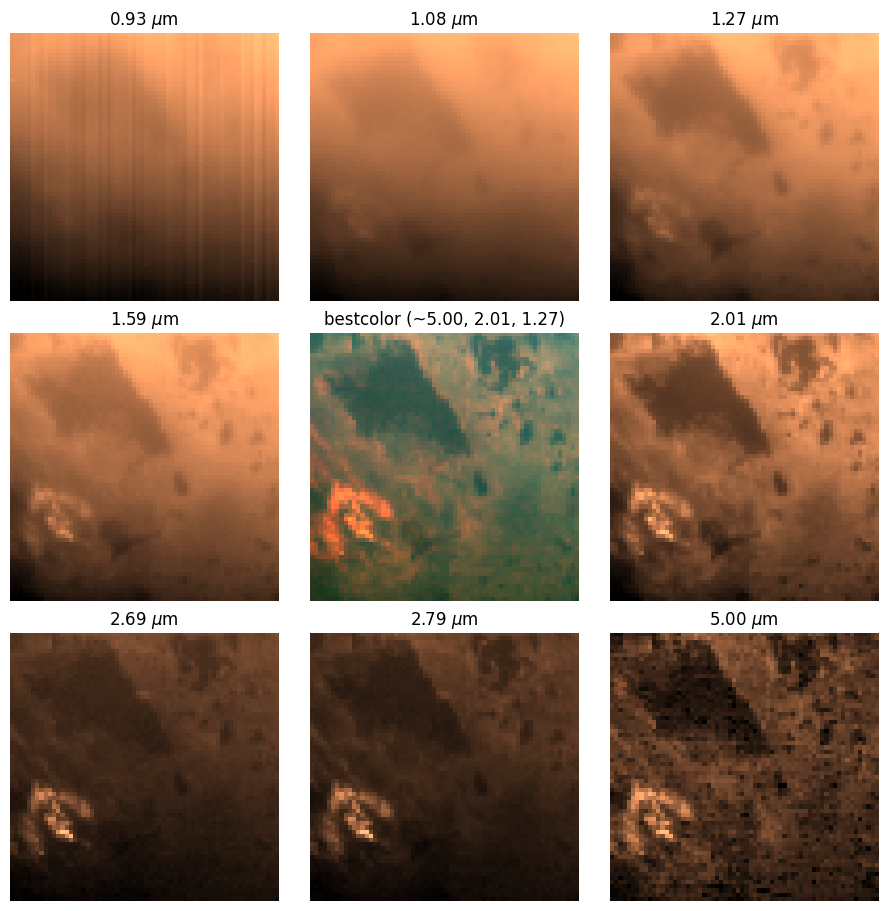

In [2]:
#DISPLAY: CUBE
#Just to show the cube we are reading in.
fig, axs = plt.subplots(3,3, figsize = (9,9), layout = "constrained") 

temp = np.transpose(cubeData)

#Windows are, according to lambertian_wholedisk:
#0.933078, 1.08183, 1.27813, 1.59018, 2.01781, 2.69620, 2.79889, 5.00576

c1 = axs[0,0].imshow((temp[windowInd[0]]), cmap="copper")
c2 = axs[0,1].imshow((temp[windowInd[1]]), cmap="copper")
c3 = axs[0,2].imshow((temp[windowInd[2]]), cmap="copper")
c4 = axs[1,0].imshow((temp[windowInd[3]]), cmap="copper")
c5 = axs[1,2].imshow((temp[windowInd[4]]), cmap="copper")
c6 = axs[2,0].imshow((temp[windowInd[5]]), cmap="copper")
c7 = axs[2,1].imshow((temp[windowInd[6]]), cmap="copper")
c8 = axs[2,2].imshow((temp[windowInd[7]]), cmap="copper")
#fig.colorbar(c4, ax=cax, label='High') 
#fig.tight_layout(pad=1.0)
axs[0,0].axis('off')
axs[0,1].axis('off')
axs[0,2].axis('off')
axs[1,0].axis('off')
axs[1,1].axis('off')
axs[1,2].axis('off')
axs[2,0].axis('off')
axs[2,1].axis('off')
axs[2,2].axis('off')
axs[1,1].axis('off')

#COLOR
#One of our colors is an average in titancolor2, so we need to grab it::
ofs = 96 #offset for when we don't have a "full" cube. It should always be 96.

if (len(zAxisCube) > 256):
    ave = (temp[336]+temp[337]+temp[338]+temp[339]+temp[340]+temp[341]
          +temp[342]+temp[343]+temp[344]+temp[345]+temp[346]+temp[347]
          +temp[348]+temp[349]+temp[350]+temp[351])/16.

    # set R, G, and B
    R = ave/(mod*1.12/16.) #Average dealing shenanigans.
    G = temp[165]/(mod*0.22)
    B = (temp[120]-0.03)/(mod*0.37)
else:
    ave = (temp[336-ofs]+temp[337-ofs]+temp[338-ofs]+temp[339-ofs]+temp[340-ofs]+temp[341-ofs]
          +temp[342-ofs]+temp[343-ofs]+temp[344-ofs]+temp[345-ofs]+temp[346-ofs]+temp[347-ofs]
          +temp[348-ofs]+temp[349-ofs]+temp[350-ofs]+temp[351-ofs])/16.

    # set R, G, and B
    R = ave/(mod*1.12/16.) #Average dealing shenanigans.
    G = temp[165-ofs]/(mod*0.22)
    B = (temp[120-ofs]-0.03)/(mod*0.37)
#B's value can introduce negatives, remove them.
i,j = 0,0
for x in B:
    j=0
    for y in x:
        if (y < 0):
            B[i][j] = 0
        j = j+1
    i = i+1

# Now we need to combine them in the correct form: xyc, that is, x, y, then color value. 
colorData = [np.transpose(R),np.transpose(G),np.transpose(B)] # arranged in cyx.
colorData = np.transpose(colorData) #arranged in xyc
#This also introduces a rotation of the image by -90 degrees. 

image = axs[1,1].imshow(colorData,origin="upper") 
#The rotation is undone here using rotate(). 

axs[0,0].set(title="0.93 $\mu$m")
axs[0,1].set(title="1.08 $\mu$m")
axs[0,2].set(title="1.27 $\mu$m")
axs[1,0].set(title="1.59 $\mu$m")
axs[1,1].set(title="bestcolor (~5.00, 2.01, 1.27)")
axs[1,2].set(title="2.01 $\mu$m")
axs[2,0].set(title="2.69 $\mu$m")
axs[2,1].set(title="2.79 $\mu$m")
axs[2,2].set(title="5.00 $\mu$m")

plt.show()

# Analysis: Data Gathering

The initial visual inspection of the model has not proven to be particuarly stunning, and thus we are forced to take another recourse. We are going to create a file that contains hand-selected pixels across various cubes so we can construct a model from observation for both Specular and Lambertian geometries. 

The procedure for gathering this data is as follows:

1) Ingest cube.

2) Display a inci emis azim grid divided into 5 degree slices, and the image itself.

3) Visually inspect cube in every area of lat-lon grid. If cube contains both lake and land, note its x and y coordinates.

4) Run next cell with the coordinates of the pixel and whether it is lake or land.

5) Cell will append a line to a file containing the data for that pixel and its 8 neighbors.

This will be a slow and ardruous and thankless process, but eventually data points will be gathered. I would love to automate this, but the issue is step 3: visual inspection is required as the code cannot reliably tell between lake and other stuff. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.08768839285714286..1.7286991071428572].


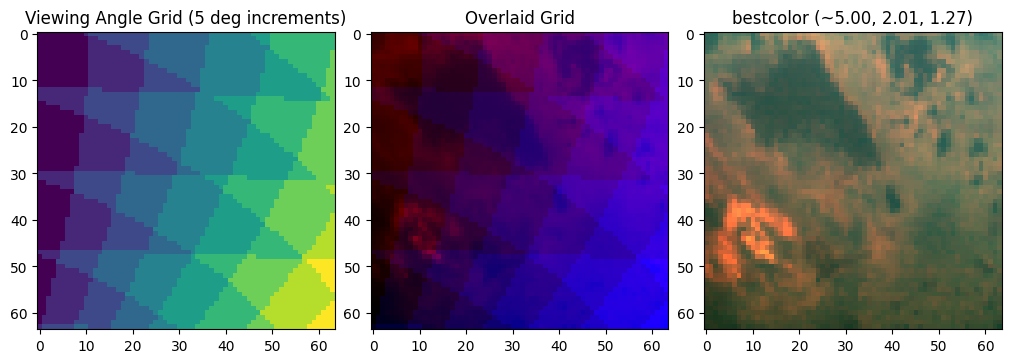

In [3]:
# DISPLAY FOR INSPECTION
fig, axs = plt.subplots(1,3, figsize = (10,4), layout = "constrained") 

#First, need to deal with azimuth separately.
azimuthData = 180 - np.transpose(np.transpose(geoIRData)[7])
if (cubeFilePath != realCube):
    i,j = 0,0
    while (i < len(xAxisCube)):
        j = 0
        while (j < len(yAxisCube)):
            p = geoIRData[i][j][4] #used to calculate azimuth.
            inci = geoIRData[i][j][5]
            emis = geoIRData[i][j][6]
            ratio = -(np.cos(np.radians(p)) - np.cos(np.radians(inci))* np.cos(np.radians(emis)))/(np.sin(np.radians(inci))*np.sin(np.radians(emis)))
            azim = np.arccos(ratio) 
            #Of course, this might be nan-ing. All the nans need their own values.
            if((math.isnan(azim) == True) and (ratio>0.)):
                azim = 0.
            elif((math.isnan(azim) == True) and (ratio<0.)):
                azim = 0.
            elif((inci==0) and (emis==0)):
                azim = 0.
            elif(math.isnan(azim) == True):
                print("Well you broke it, great. (Azimuth is nan, but could not be set to anything else.)")
            azimuthData[i][j] = math.degrees(azim)
            j = j+1
        i = i+1   

angleGrid = np.around(np.transpose(geoIRData)[5]/5.)*5. + np.around(np.transpose(geoIRData)[6]/5.)*5. + np.around(np.transpose(azimuthData)/5.)*5.
c1 = axs[0].imshow(angleGrid, cmap="viridis")
axs[0].set(title="Viewing Angle Grid (5 deg increments)")

angleGrid = angleGrid - np.amin(angleGrid)
angleGrid = angleGrid/np.amax(angleGrid)
newG = G-np.amin(G)
newG = newG/np.amax(newG)
overlaidGrid = [np.transpose(newG/2.), np.transpose(G*0), np.transpose(angleGrid)]
overlaidGrid = np.transpose(overlaidGrid)

image = axs[1].imshow(overlaidGrid,origin="upper")
axs[1].set(title="Overlaid Grid")

image = axs[2].imshow(colorData,origin="upper")
axs[2].set(title="bestcolor (~5.00, 2.01, 1.27)")

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..447.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.08768839285714286..1.7286991071428572].


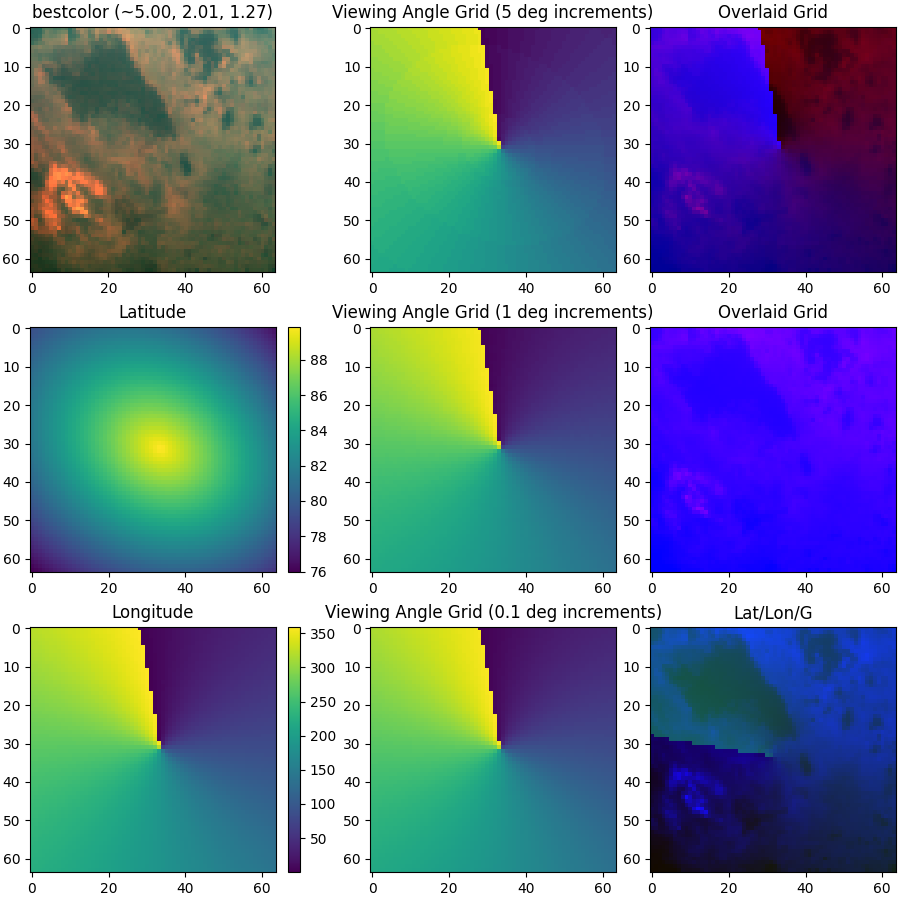

In [4]:
# DISPLAY FOR INSPECTION
%matplotlib ipympl
fig, axs = plt.subplots(3,3, figsize = (9,9), layout = "constrained") 

latim = axs[1][0].imshow(np.transpose(geoIRData)[0],origin="upper")
axs[1][0].set(title="Latitude")
fig.colorbar(latim,ax=axs[1][0])
lonim = axs[2][0].imshow(np.transpose(geoIRData)[1],origin="upper")
axs[2][0].set(title="Longitude")
fig.colorbar(lonim,ax=axs[2][0])

angleGrid = np.around(np.transpose(geoIRData)[0]/5.)*5. + np.around(np.transpose(geoIRData)[1]/5.)*5.
c1 = axs[0][1].imshow(angleGrid, cmap="viridis")
axs[0][1].set(title="Viewing Angle Grid (5 deg increments)")

angleGrid2 = np.around(np.transpose(geoIRData)[0]/1.)*1. + np.around(np.transpose(geoIRData)[1]/1.)*1.
c2 = axs[1][1].imshow(angleGrid2, cmap="viridis")
axs[1][1].set(title="Viewing Angle Grid (1 deg increments)")

angleGrid3 = np.around(np.transpose(geoIRData)[0]/0.1)*0.1 + np.around(np.transpose(geoIRData)[1]/0.1)*0.1
c3 = axs[2][1].imshow(angleGrid3, cmap="viridis")
axs[2][1].set(title="Viewing Angle Grid (0.1 deg increments)")

angleGrid = angleGrid - np.amin(angleGrid)
angleGrid = angleGrid/np.amax(angleGrid)
newG = G-np.amin(G)
newG = newG/np.amax(newG)
overlaidGrid = [np.transpose(newG/2.), np.transpose(G*0), np.transpose(angleGrid)]
overlaidGrid = np.transpose(overlaidGrid)
overlaidGrid2 = [np.transpose(newG/2.), np.transpose(G*0), np.transpose(angleGrid2)]
overlaidGrid2 = np.transpose(overlaidGrid2)

overlaidGrid3 = [np.absolute(np.transpose(geoIRData)[0]/1000.), np.transpose(geoIRData)[1]/1000., np.transpose(newG)]
overlaidGrid3 = np.transpose(overlaidGrid3)

image = axs[0][2].imshow(overlaidGrid,origin="upper")
axs[0][2].set(title="Overlaid Grid")
image = axs[1][2].imshow(overlaidGrid2,origin="upper")
axs[1][2].set(title="Overlaid Grid")
image = axs[2][2].imshow(overlaidGrid3,origin="upper")
axs[2][2].set(title="Lat/Lon/G")

image = axs[0][0].imshow(colorData,origin="upper")
axs[0][0].set(title="bestcolor (~5.00, 2.01, 1.27)")

plt.show()

And for each image run the next cell as many times as desired to get every cell the image has. If a single cell has large lambertian and specular components, it's possible to run them both. We don't save the *rounded* viewing angles, but the actual ones. 

NOTE: This broke when using PyVIMS. It's easy to tell as it blows the angles up to 1000s of degrees, but yeesh. Just apply the "to rad" funciton to get degrees. Endlessly confusing but it is what it is, already ran the data.

In [5]:
# ADD TO FILE
xo = 17 #x coordinate, "o" means it's the original.
yo = 5 #y coordinate
kind = "L" #S is specular, L is lambertian. Ish. Star means things are questinable.

if (kind == "L"):
    file='PixelGatheringL.csv'
elif (kind == "S"):
    file='PixelGatheringS.csv'

flybyNum = "T93"
    
#xAxisCube, yAxisCube, use well.
with open(file, 'a') as dataEntry: #a for append.
    i=-1
    j=-1
    while (i <= 1):
        j = -1
        while (j <= 1):
            
            x = xo+i
            y = yo+j

            #For every pixel... start the outfile line.
            outfile = cubeNum + "," #this is a CSV after all.
            outfile = outfile + flybyNum + ","
            outfile = outfile + str(x) + "," + str(y) + "," #Pixel Coordinates
            outfile = outfile + kind + ","
            print(x,y)
            outfile = outfile + str(geoIRData[x][y][0]) + "," + str(geoIRData[x][y][1]) + "," #Latlon
            inci = geoIRData[x][y][5]
            emis = geoIRData[x][y][6]
            azim = 0.
            if (usePyVIMS == True):
                azim = 180 - geoIRData[x][y][7] #The azim is evidentially defined in the reverse manner
                # in the pyVIMS database
            else:
                #Azimuth formula from Jason Barnes' phasecurve.c++
                p = geoIRData[x][y][4] #used to calculate azimuth.
                ratio = -(np.cos(np.radians(p)) - np.cos(np.radians(inci))* np.cos(np.radians(emis)))/(np.sin(np.radians(inci))*np.sin(np.radians(emis)))
                azim = np.arccos(ratio)
                #Of course, this might be nan-ing. All the nans need their own values.
            if((math.isnan(azim) == True) and (ratio>0.)):
                azim = 0.
            elif((math.isnan(azim) == True) and (ratio<0.)):
                azim = 0.
            elif((inci==0) and (emis==0)):
                azim = 0.
            elif(math.isnan(azim) == True):
                print("Well you broke it, great. (Azimuth is nan, but could not be set to anything else.)")
            if (inci < 0):
                inci = 0
            elif (inci > 100):
                inci = 100
            if (emis < 0):
                emis = 0
            elif (emis > 90):
                emis = 90
            if (azim < 0):
                azim = 0
            if (azim > 180):
                azim = 180

            outfile = outfile + str(inci) + "," + str(emis) + "," #inci emis
            outfile = outfile + str(math.degrees(azim)) + "," #azimuth
            outfile = outfile + str(geoIRData[x][y][2]) + "," + str(geoIRData[x][y][4]) + "," #res phase

            #Now we need the window wavelengths, which means we need to *read* the data itself.
            outfile = outfile + str(np.transpose(temp[windowInd[0]])[x][y]) + "," 
            outfile = outfile + str(np.transpose(temp[windowInd[1]])[x][y]) + "," 
            outfile = outfile + str(np.transpose(temp[windowInd[2]])[x][y]) + "," 
            outfile = outfile + str(np.transpose(temp[windowInd[3]])[x][y]) + "," 
            outfile = outfile + str(np.transpose(temp[windowInd[4]])[x][y]) + "," 
            outfile = outfile + str(np.transpose(temp[windowInd[5]])[x][y]) + "," 
            outfile = outfile + str(np.transpose(temp[windowInd[6]])[x][y]) + "," 
            outfile = outfile + str(np.transpose(temp[windowInd[7]])[x][y]) + "," + "\n"

            print(outfile)

            #dataEntry.write(outfile)
            j = j+1
        i = i+1

16 4
CM_1787307197_1,T93,16,4,L,81.986954,337.242523,60.30022,42.094925,24.673906004171698,10.723167,99.293266,0.193594,0.150642,0.161784,0.113707,0.094521,0.037133,0.035479,0.017268,

16 5
CM_1787307197_1,T93,16,5,L,82.203552,336.096802,60.561409,41.82375,24.697169789537867,10.747905,99.285919,0.191193,0.14922,0.157932,0.111843,0.092071,0.035823,0.035479,0.027628,

16 6
CM_1787307197_1,T93,16,6,L,82.428421,335.027954,60.82526,41.559948,24.761540036678433,10.774723,99.278122,0.187593,0.146274,0.153814,0.10918,0.08857,0.034949,0.03427,0.024175,

17 4
CM_1787307197_1,T93,17,4,L,82.065384,338.867035,60.2901,42.21484,25.08474610527155,10.745538,99.292862,0.191869,0.14983,0.158729,0.112109,0.092071,0.035386,0.03427,0.027628,

17 5
CM_1787307197_1,T93,17,5,L,82.286812,337.758362,60.551388,41.943939,25.109882987138253,10.770167,99.285515,0.188697,0.147493,0.153416,0.108115,0.083669,0.034075,0.033463,0.017268,

17 6
CM_1787307197_1,T93,17,6,L,82.516129,336.731232,60.815308,41.68063,25.17602093

Now that we've created the file and the data, we can use it all to create a model, and compare it to the *other* model. But first let's kind of just take a look at what we *have*. What viewing geometries actually exist? To do this we shall plot some scatters of the viewing angles: inci, emis, azim. Three different plots showing their relation to each other should do the trick, though if it doesn't we can always plot a cube.

In [6]:
# Read in the files
inciP = []
emisP = []
azimP = []
with open("C:\\Users\\deran\\Desktop\\GMsNotes\\SCRATCH WORK\\MaskMaker\\pixelResults.csv") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        inciP.append(float(row[7]))
        emisP.append(float(row[8]))
        if (float(row[9]) > 200.):
            azimP.append(math.radians(float(row[9])))
        else:
            azimP.append(float(row[9]))
        line_count += 1
#11 is the special distance. Sign is used to differentiate lake from land.

In [7]:
#set up the things that will hold it all.
X = 21
Y = 19
Z = 37

select = 17 #Value we select for. 17 should be 2um.

realBinsL = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
realBinsLNum = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] #LAKES
realBinsP = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
realBinsPNum = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] #PLAINS
realBinsD = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
realBinsDNum = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] #DUNES
realBinsX = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
realBinsXNum = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] #XANADU
realBinsH = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
realBinsHNum = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] #HUMMOCKY
realBinsR = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
realBinsRNum = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] #LABYRINTHS
realBinsC = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
realBinsCNum = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] #CRATERS


#Read the data in, counting how many times we hit each bin.
with open("C:\\Users\\deran\\Desktop\\GMsNotes\\SCRATCH WORK\\MaskMaker\\pixelResults.csv") as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        inci = float(row[7])
        emis = float(row[8])
        if (float(row[9]) > 200.):
            azim = math.radians(float(row[9]))
        else:
            azim = float(row[9])
        #Our goal is to convert these to indices for every "5" degrees.
        #So, divide by 5 then round to get the index. 
        if (float(row[11]) < 0):
            realBinsLNum[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] = realBinsLNum[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] + 1
            realBinsL[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] = realBinsL[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] + float(row[select])
        else:
            realBinsSNum[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] = realBinsSNum[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] + 1
            realBinsS[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] = realBinsS[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] + float(row[select])
        line_count += 1
i,j,k = 0,0,0
while (i < X):
    j = 0
    while (j < Y):
        k = 0
        while (k < Z):
            if (realBinsSNum[i][j][k] != 0):
                realBinsS[i][j][k] = realBinsS[i][j][k] / float(realBinsSNum[i][j][k] )
            if (realBinsLNum[i][j][k] != 0):
                realBinsL[i][j][k] = realBinsL[i][j][k] / float(realBinsLNum[i][j][k] )
            #Divide out the total additions so we get an average value.
            k=k+1
        j=j+1
    i=i+1


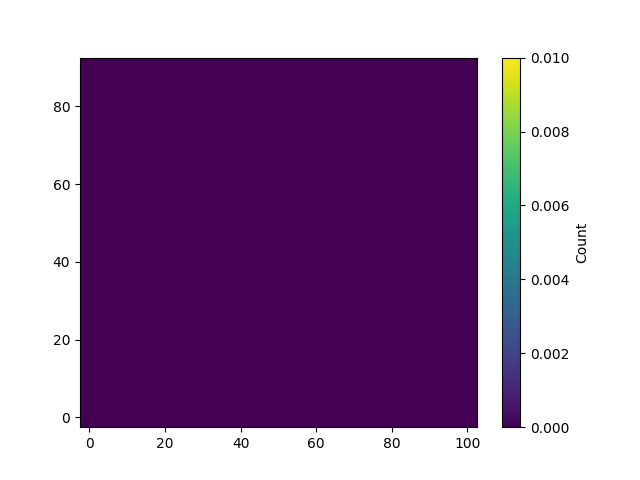

In [8]:
%matplotlib ipympl

fig, ax = plt.subplots() #matplotlib's axis and figure notation is so annoying and obtuse...

#Now we'd like to try to animate it. 
#https://matplotlib.org/stable/users/explain/animations/animations.html
#Eventually had to use ChatGPT to help here. Could not get the ArtistAnimator to work, but it could
#get the FuncAnimation to work--evidentially defining zz inside the funciton/loop was important.
#Even though I thought I already tried that...

#Now we actually need to get the slices
#Set up x and y divisions.        
xx = np.linspace(0, 100, 21)
yy = np.linspace(0, 90, 19)

#The scale value for how much color detail we want:
cmap = 'viridis'
vmin=0
vmax=0.01

c = ax.pcolor(xx,yy, np.zeros((Y, X)), cmap=cmap,vmin=vmin,vmax=vmax)
fig.colorbar(c, ax=ax, label='Count')
# annoyance of animation: trying to update the color bar duplicates it.
# so we need a "dummy" plot to initialize it before we start animating. 

#Making an array so the title can display the azimuth angle. 
angles = ["000", "005", "010", "015", "020", "025", "030", "035", "040", "045", "050", "055", "060", "065", "070", "075",
             "080", "085", "090", "095", "100", "105", "110", "115", "120", "125", "130", "135", "140", "145", "150", "155",
             "160", "165", "170", "175", "180"] 

def update(frame):
    ax.clear()
    zz = np.zeros((Y, X))
    for x in range(X):
        for y in range(Y):
            zz[y][x] = realBinsS[x][y][frame]
    azimuth = ax.pcolor(xx, yy, zz, cmap=cmap,vmin=vmin,vmax=vmax)
    ax.set(xlim=[-2.5,102.5], ylim=[-2.5,92.5], xlabel='Incidence Angle', ylabel='Emission Angle', 
           title = 'Viewing Angle Bin Counts. Azimuth: '+str(angles[frame])+ ' degrees')
    

ani = animation.FuncAnimation(fig, update, frames=Z, interval=500)

# To save the animation using Pillow as a gif. Use FFMpegFileWriter for mp4. 
#writer = animation.FFMpegFileWriter(fps = 2)
#ani.save('TEST2.mp4', writer = writer)
#writer = animation.PillowWriter(fps=5)
#ani.save('TEST2.gif', writer=writer)

plt.show()

In [9]:
ani.pause()
plt.close()

In [10]:
#IMPORTS
import math
import numpy as np
import pyvista as pv

#INPUT: a 3D array. We happen to have one constructed from the above notebook, but in actual use this will be
#defined or input some other way.
inputMatrix = realBinsS
inputMatrix2 = realBinsL

#EXTRACT: Identify where the actual point values are in the matrix, and put them in an array.
pointArray = []
i,j,k = 0,0,0
for x in range(len(inputMatrix)):
    j = 0
    for y in range (len(inputMatrix[0])):
        k = 0
        for z in range (len(inputMatrix[0][0])):
            if (inputMatrix[i][j][k] != 0):
                pointArray.append([i,j,k])
            k = k+1
        j = j+1
    i = i+1

pointArray2 = []
i,j,k = 0,0,0
for x in range(len(inputMatrix2)):
    j = 0
    for y in range (len(inputMatrix2[0])):
        k = 0
        for z in range (len(inputMatrix2[0][0])):
            if (inputMatrix2[i][j][k] != 0):
                pointArray2.append([i,j,k])
            k = k+1
        j = j+1
    i = i+1

#TETRAHEDRALIZE: Divide up the points into tetrahedron cells.
mesh = pv.PolyData(pointArray).delaunay_3d() #turns points into mesh, then draws the tetrahedrons.
mesh2 = pv.PolyData(pointArray2).delaunay_3d() #turns points into mesh, then draws the tetrahedrons.

#INTERPOLATE: For every "pixel" in the matrix, find a value if possible.
#Fortunately if "not inside any cell" occurs, the method returns -1, an easy check.
finalMatrix = [[[0 for x in range(len(inputMatrix[0][0]))] for x in range(len(inputMatrix[0]))] for x in range(len(inputMatrix))]
i,j,k = 0,0,0
for x in range(len(inputMatrix)):
    j = 0
    for y in range (len(inputMatrix[0])):
        k = 0
        for z in range (len(inputMatrix[0][0])):
            if (inputMatrix[i][j][k] != 0):
                finalMatrix[i][j][k] = inputMatrix[i][j][k]
                #If we are on a point, don't bother interpolating. 
            else:
                cellNum = mesh.find_containing_cell([i,j,k])
                if (cellNum == -1):
                    finalMatrix[i][j][k] = -1
                    #Exterior Values get Zero'd
                else:
                    cell = mesh.get_cell(cellNum)
                    cellPoints = cell.points
                    #And now we can do the actual interpolation.
                    pointVals = []
                    iter = 0
                    while (iter < 4):
                        pointVals.append(inputMatrix[int(cellPoints[iter][0])][int(cellPoints[iter][1])][int(cellPoints[iter][2])])
                        iter=iter+1
                    #pointVals hold the values at all points.
                    #Now the matrix magic is below
                    M = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V = (1./6.)*np.absolute(np.linalg.det(M))
                    M1 = [[float(i),float(j),float(k),1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V1 = (1./6.)*np.absolute(np.linalg.det(M1))
                    M2 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [float(i),float(j),float(k),1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V2 = (1./6.)*np.absolute(np.linalg.det(M2))
                    M3 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [float(i),float(j),float(k),1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V3 = (1./6.)*np.absolute(np.linalg.det(M3))
                    M4 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [float(i),float(j),float(k),1.0]]
                    V4 = (1./6.)*np.absolute(np.linalg.det(M4))
                    #print(V, V1, V2, V3, V4, V1+V2+V3+V4)
                    #The volumes of each of these segments correspond to the vertex not part of their calculation.
                    #Thus we interpolate with simple divisions:
                    interpVal = pointVals[0]*(V1/V) + pointVals[1]*(V2/V) + pointVals[2]*(V3/V) + pointVals[3]*(V4/V)
                    finalMatrix[i][j][k] = float(interpVal)                    
            k = k+1
        j = j+1
    i = i+1

finalMatrix2 = [[[0 for x in range(len(inputMatrix2[0][0]))] for x in range(len(inputMatrix2[0]))] for x in range(len(inputMatrix2))]
i,j,k = 0,0,0
for x in range(len(inputMatrix2)):
    j = 0
    for y in range (len(inputMatrix2[0])):
        k = 0
        for z in range (len(inputMatrix2[0][0])):
            if (inputMatrix2[i][j][k] != 0):
                finalMatrix2[i][j][k] = inputMatrix2[i][j][k]
                #If we are on a point, don't bother interpolating. 
            else:
                cellNum = mesh2.find_containing_cell([i,j,k])
                if (cellNum == -1):
                    finalMatrix2[i][j][k] = -1
                    #Exterior Values get Negative'd
                else:
                    cell = mesh2.get_cell(cellNum)
                    cellPoints = cell.points
                    #And now we can do the actual interpolation.
                    pointVals = []
                    iter = 0
                    while (iter < 4):
                        pointVals.append(inputMatrix2[int(cellPoints[iter][0])][int(cellPoints[iter][1])][int(cellPoints[iter][2])])
                        iter=iter+1
                    #pointVals hold the values at all points.
                    #Now the matrix magic is below
                    M = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V = (1./6.)*np.absolute(np.linalg.det(M))
                    M1 = [[float(i),float(j),float(k),1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V1 = (1./6.)*np.absolute(np.linalg.det(M1))
                    M2 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [float(i),float(j),float(k),1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V2 = (1./6.)*np.absolute(np.linalg.det(M2))
                    M3 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [float(i),float(j),float(k),1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V3 = (1./6.)*np.absolute(np.linalg.det(M3))
                    M4 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [float(i),float(j),float(k),1.0]]
                    V4 = (1./6.)*np.absolute(np.linalg.det(M4))
                    #print(V, V1, V2, V3, V4, V1+V2+V3+V4)
                    #The volumes of each of these segments correspond to the vertex not part of their calculation.
                    #Thus we interpolate with simple divisions:
                    interpVal = pointVals[0]*(V1/V) + pointVals[1]*(V2/V) + pointVals[2]*(V3/V) + pointVals[3]*(V4/V)
                    finalMatrix2[i][j][k] = float(interpVal)                    
            k = k+1
        j = j+1
    i = i+1
#print(finalMatrix)

C:\Users\deran\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyvista\core\utilities\points.py:55: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(


[0.03028, 0.030042, 0.031658, 0.033164, 0.035488, 0.03848, 0.043386, 0.050109, 0.057651, 0.069564, 0.084548, 0.101398, 0.121574, 0.14829, 0.183457, 0.226889, 0.27564, 0.3239, 0.363635]


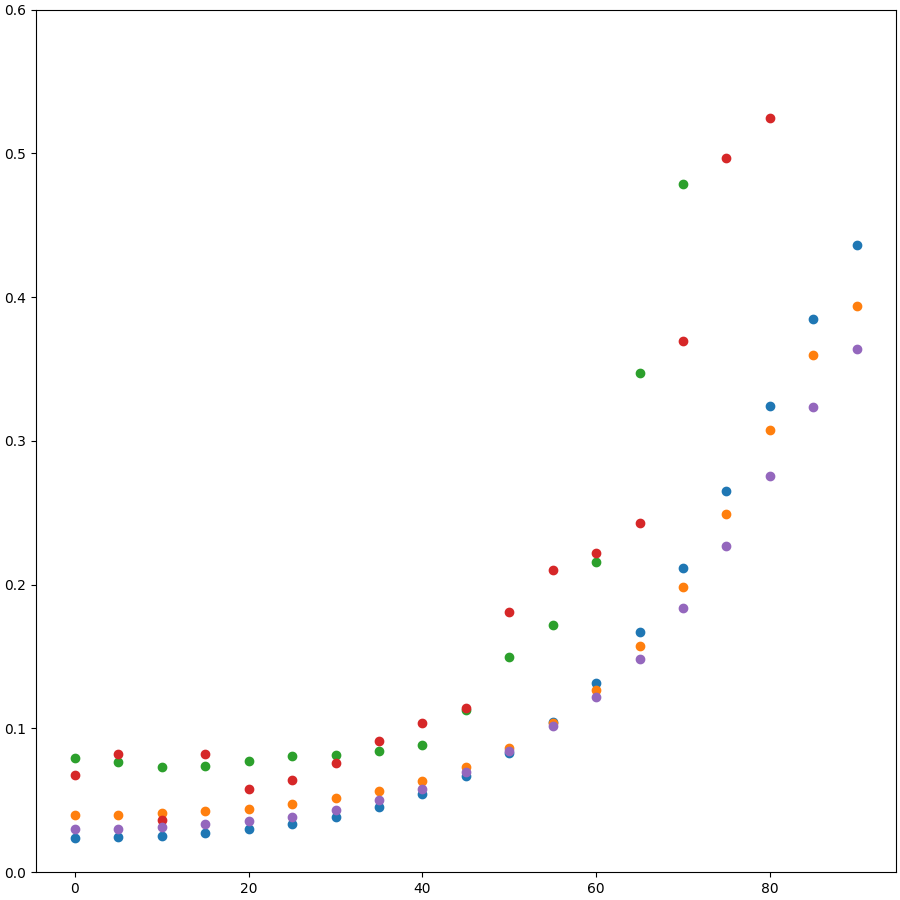

In [11]:
# CUT A LINE AND COMPARE
# This really isn't a presentation notebook anymore, huh?
# Anyway we just need to look at a particular slice. We have chosen 2um 25 azim and 65 incidence. The emission angle is the dependent variable.
# We need to plot the specular model, the lake data, and the land data. 
#(Lambertian model is probably useuless, but we can go ahead and plot it I suppose).
#Each series should have 19 data values.
specModel = []
lambModel = []
lakeData = []
landData = []
specialData = []
Eangles = []

azim = 5 #azimuth, 5=25 degrees.
inci = 13 #incidence, 13=65 degrees.

i = 0
while (i < 19):
    specModel.append(dataWin5[inci][i][azim])
    lambModel.append(dataWin5L[inci][i][azim])
    lakeData.append(finalMatrix[inci][i][azim])
    landData.append(finalMatrix2[inci][i][azim])
    specialData.append(dataWinSpecial[inci][i][azim])
    Eangles.append(i*5.)
    i=i+1

#The problem here is that these things aren't in the same scale domian, makes it hard to compare. So we need to reclaim the
#line's shape without altering anything else. The problem is our sets of data have different lengths! 
#One may think the derivative may help, but it also scales based on the actual values. But you know what doesn't? 
#Multiplicity. The number you multiply one point by to get the next, that is a scale-invariant quantity. We can use that
#To extract generic shapes. Cycle through and alter everything according to this.

fig, ax = plt.subplots(figsize = (9,9), layout="constrained") #matplotlib's axis and figure notation is so annoying and obtuse...

ax.scatter(Eangles, np.array(specModel)*8.)
ax.scatter(Eangles, np.array(lambModel)*8.)
ax.scatter(Eangles, lakeData)
ax.scatter(Eangles, landData)
ax.scatter(Eangles, np.array(specialData))

print(specialData)

ax.set(ylim = [0.0,0.6])

plt.show()

In [12]:
ani.pause()
plt.close()

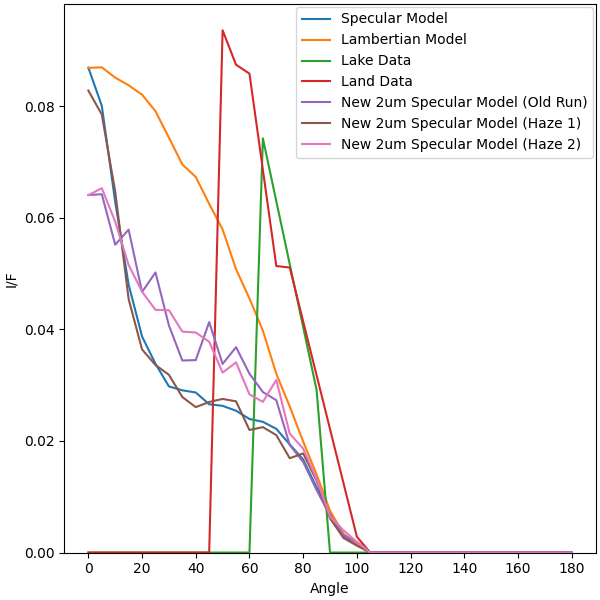

In [26]:
plt.close()
import mpl_interactions.ipyplot as iplt
fig, ax = plt.subplots(figsize = (6,6), layout="constrained") #matplotlib's axis and figure notation is so annoying and obtuse...

angleSpace = np.linspace(0, 180, 37)
inciSpace = np.linspace(0, 100, 21)
emisSpace = np.linspace(0, 90, 19)
azimSpace = np.linspace(0, 180, 37)
typeSpace = np.linspace(1,3,3)

def SM(inci,emis,azim,types):
    theLine = []
    inci =int(inci/5)
    emis =int(emis/5)
    azim =int(azim/5)
    types =int(types)

    i = 0
    if (types == 1):
        while (i < 21):
            theLine.append(dataWin5[i][emis][azim]*8)
            i=i+1
    if (types == 2):
        while (i < 19):
            theLine.append(dataWin5[inci][i][azim]*8)
            i=i+1
    if (types == 3):
        while (i < 37):
            theLine.append(dataWin5[inci][emis][i]*8)
            i=i+1

    while (i < 37):
        theLine.append(0.)
        i=i+1
    
    return theLine
def LM(inci,emis,azim,types):
    theLine = []
    inci =int(inci/5)
    emis =int(emis/5)
    azim =int(azim/5)
    types =int(types)

    i = 0
    if (types == 1):
        while (i < 21):
            theLine.append(dataWin5L[i][emis][azim]*8)
            i=i+1
    if (types == 2):
        while (i < 19):
            theLine.append(dataWin5L[inci][i][azim]*8)
            i=i+1
    if (types == 3):
        while (i < 37):
            theLine.append(dataWin5L[inci][emis][i]*8)
            i=i+1

    while (i < 37):
        theLine.append(0.)
        i=i+1
    
    return theLine
def LkD(inci,emis,azim,types):
    theLine = []
    inci =int(inci/5)
    emis =int(emis/5)
    azim =int(azim/5)
    types =int(types)

    i = 0
    if (types == 1):
        while (i < 21):
            theLine.append(finalMatrix[i][emis][azim])
            if(theLine[i] <0): theLine[i] = 0
            i=i+1
    if (types == 2):
        while (i < 19):
            theLine.append(finalMatrix[inci][i][azim])
            if(theLine[i] <0): theLine[i] = 0
            i=i+1
    if (types == 3):
        while (i < 37):
            theLine.append(finalMatrix[inci][emis][i])
            if(theLine[i] <0): theLine[i] = 0
            i=i+1

    while (i < 37):
        theLine.append(0.)
        i=i+1
    
    return theLine
def LnD(inci,emis,azim,types):
    theLine = []
    inci =int(inci/5)
    emis =int(emis/5)
    azim =int(azim/5)
    types =int(types)

    i = 0
    if (types == 1):
        while (i < 21):
            theLine.append(finalMatrix2[i][emis][azim])
            if(theLine[i] <0): theLine[i] = 0
            i=i+1
    if (types == 2):
        while (i < 19):
            theLine.append(finalMatrix2[inci][i][azim])
            if(theLine[i] <0): theLine[i] = 0
            i=i+1
    if (types == 3):
        while (i < 37):
            theLine.append(finalMatrix2[inci][emis][i])
            if(theLine[i] <0): theLine[i] = 0
            i=i+1

    while (i < 37):
        theLine.append(0.)
        i=i+1
    
    return theLine

def SpecialD(inci,emis,azim,types):
    theLine = []
    inci =int(inci/5)
    emis =int(emis/5)
    azim =int(azim/5)
    types =int(types)

    i = 0
    if (types == 1):
        while (i < 21):
            theLine.append(dataWinSpecial[i][emis][azim]) #No need to multiply by 8 as this was calculated without other wavelenghts. Yes, an original code oversight.
            i=i+1
    if (types == 2):
        while (i < 19):
            theLine.append(dataWinSpecial[inci][i][azim])
            i=i+1
    if (types == 3):
        while (i < 37):
            theLine.append(dataWinSpecial[inci][emis][i])
            i=i+1

    while (i < 37):
        theLine.append(0.)
        i=i+1
    
    return theLine

def SpecialD1(inci,emis,azim,types):
    theLine = []
    inci =int(inci/5)
    emis =int(emis/5)
    azim =int(azim/5)
    types =int(types)

    i = 0
    if (types == 1):
        while (i < 21):
            theLine.append(dataWinSpecial1[i][emis][azim]) #No need to multiply by 8 as this was calculated without other wavelenghts. Yes, an original code oversight.
            i=i+1
    if (types == 2):
        while (i < 19):
            theLine.append(dataWinSpecial1[inci][i][azim])
            i=i+1
    if (types == 3):
        while (i < 37):
            theLine.append(dataWinSpecial1[inci][emis][i])
            i=i+1

    while (i < 37):
        theLine.append(0.)
        i=i+1
    
    return theLine

def SpecialD2(inci,emis,azim,types):
    theLine = []
    inci =int(inci/5)
    emis =int(emis/5)
    azim =int(azim/5)
    types =int(types)

    i = 0
    if (types == 1):
        while (i < 21):
            theLine.append(dataWinSpecial2[i][emis][azim]) #No need to multiply by 8 as this was calculated without other wavelenghts. Yes, an original code oversight.
            i=i+1
    if (types == 2):
        while (i < 19):
            theLine.append(dataWinSpecial2[inci][i][azim])
            i=i+1
    if (types == 3):
        while (i < 37):
            theLine.append(dataWinSpecial2[inci][emis][i])
            i=i+1

    while (i < 37):
        theLine.append(0.)
        i=i+1
    
    return theLine

angleLabels = [0, 20, 40, 60,
             80, 100, 120, 140,
             160, 180] 

ticker = [0,4,8,12,16,20,24,28,32,36]

controls = iplt.plot(SM, inci=inciSpace, emis=emisSpace, azim=azimSpace, types=typeSpace, ax = ax, label="Specular Model")
iplt.plot(LM, controls=controls, ax = ax, label="Lambertian Model")
iplt.plot(LkD, controls=controls, ax = ax, label="Lake Data")
iplt.plot(LnD, controls=controls, ax = ax, label="Land Data")
iplt.plot(SpecialD, controls=controls, ax = ax, label="New 2um Specular Model (Old Run)")
iplt.plot(SpecialD1, controls=controls, ax = ax, label="New 2um Specular Model (Haze 1)")
iplt.plot(SpecialD2, controls=controls, ax = ax, label="New 2um Specular Model (Haze 2)")
ax.set(ylim = 0.0,xlabel = "Angle", ylabel = "I/F", xticks = ticker, xticklabels = angleLabels)
fig.legend()
#plt.savefig("TitanColorSchemes.tif", format="tif", bbox_inches='tight')

plt.show()

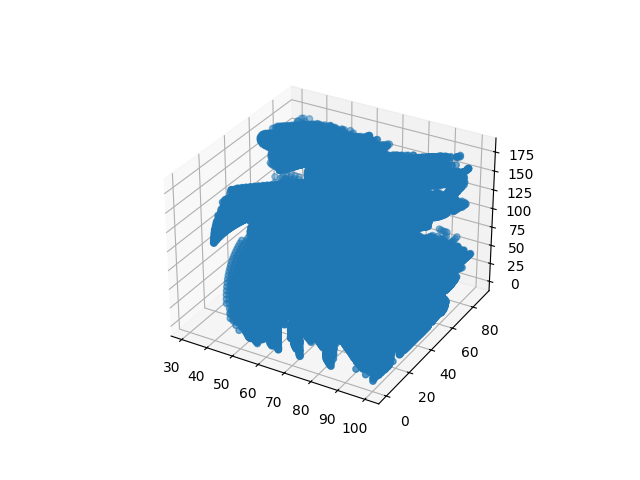

In [12]:
#3D?
%matplotlib ipympl
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(inciP,emisP,azimP)

plt.show()

In [11]:
plt.close()

STUFF BELOW HERE IS OLD; CODE KEPT FOR REFERENCE PURPOSES

In [6]:
# Read in the files
inciS = []
emisS = []
azimS = []
inciL = []
emisL = []
azimL = []
with open('PixelGatheringS.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        inciS.append(float(row[7]))
        emisS.append(float(row[8]))
        if (float(row[9]) > 200.):
            azimS.append(math.radians(float(row[9])))
        else:
            azimS.append(float(row[9]))
        line_count += 1
with open('PixelGatheringL.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        inciL.append(float(row[7]))
        emisL.append(float(row[8]))
        if (float(row[9]) > 200.):
            azimL.append(math.radians(float(row[9])))
        else:
            azimL.append(float(row[9]))
        line_count += 1

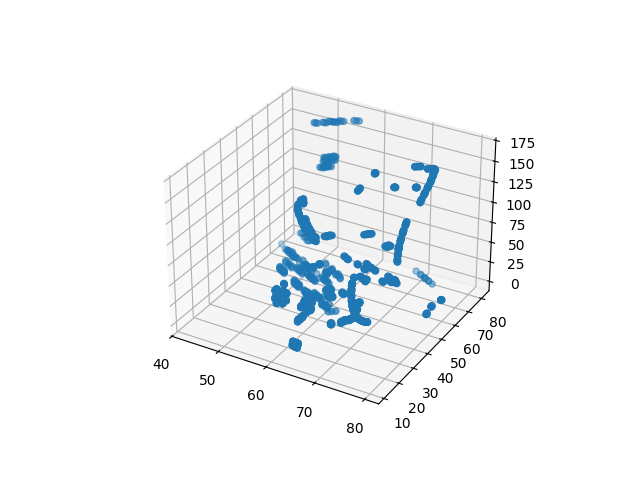

In [7]:
#3D?
%matplotlib ipympl
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(inciS,emisS,azimS)

plt.show()

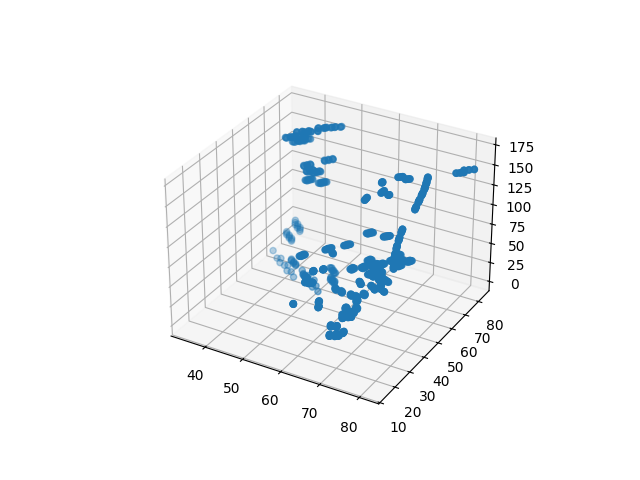

In [8]:
#3D?
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(inciL,emisL,azimL)

plt.show()

Let's bin everything. Incidence, Emission, Azimuth, a 3D matrix.



In [9]:
#set up the things that will hold it all.
#BAD ONE. NEXT CELL UNDOES THIS. 
"""
X = 21*5
Y = 19*5
Z = 181

realBinsS = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
realBinsL = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 

#Read the data in, counting how many times we hit each bin.
with open('PixelGatheringS.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        inci = float(row[7])
        emis = float(row[8])
        if (float(row[9]) > 200.):
            azim = math.radians(float(row[9]))
        else:
            azim = float(row[9])
        #Our goal is to convert these to indices for every "5" degrees.
        #So, divide by 5 then round to get the index. 
        realBinsS[int(np.round(inci))][int(np.round(emis))][int(np.round(azim))] = realBinsS[int(np.round(inci))][int(np.round(emis))][int(np.round(azim))] + 1
        line_count += 1
with open('PixelGatheringL.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        inci = float(row[7])
        emis = float(row[8])
        if (float(row[9]) > 200.):
            azim = math.radians(float(row[9]))
        else:
            azim = float(row[9])
        #Our goal is to convert these to indices for every "5" degrees.
        #So, divide by 5 then round to get the index. 
        realBinsL[int(np.round(inci))][int(np.round(emis))][int(np.round(azim))] = realBinsS[int(np.round(inci))][int(np.round(emis))][int(np.round(azim))] + 1
        line_count += 1
        
"""

'\nX = 21*5\nY = 19*5\nZ = 181\n\nrealBinsS = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] \nrealBinsL = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] \n\n#Read the data in, counting how many times we hit each bin.\nwith open(\'PixelGatheringS.csv\') as csv_file:\n    csv_reader = csv.reader(csv_file, delimiter=\',\')\n    line_count = 0\n    for row in csv_reader:\n        inci = float(row[7])\n        emis = float(row[8])\n        if (float(row[9]) > 200.):\n            azim = math.radians(float(row[9]))\n        else:\n            azim = float(row[9])\n        #Our goal is to convert these to indices for every "5" degrees.\n        #So, divide by 5 then round to get the index. \n        realBinsS[int(np.round(inci))][int(np.round(emis))][int(np.round(azim))] = realBinsS[int(np.round(inci))][int(np.round(emis))][int(np.round(azim))] + 1\n        line_count += 1\nwith open(\'PixelGatheringL.csv\') as csv_file:\n    csv_reader = csv.reader(csv_file, del

In [10]:
#set up the things that will hold it all.
X = 21
Y = 19
Z = 37

select = 16 #Value we select for. 16 should be 2um.

realBinsS = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
realBinsSNum = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
realBinsL = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 
realBinsLNum = [[[0 for x in range(Z)] for x in range(Y)] for x in range(X)] 

#Read the data in, counting how many times we hit each bin.
with open('PixelGatheringS.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        inci = float(row[7])
        emis = float(row[8])
        if (float(row[9]) > 200.):
            azim = math.radians(float(row[9]))
        else:
            azim = float(row[9])
        #Our goal is to convert these to indices for every "5" degrees.
        #So, divide by 5 then round to get the index. 
        realBinsSNum[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] = realBinsSNum[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] + 1
        realBinsS[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] = realBinsS[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] + float(row[select])
        line_count += 1
with open('PixelGatheringL.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        inci = float(row[7])
        emis = float(row[8])
        if (float(row[9]) > 200.):
            azim = math.radians(float(row[9]))
        else:
            azim = float(row[9])
        #Our goal is to convert these to indices for every "5" degrees.
        #So, divide by 5 then round to get the index. 
        realBinsLNum[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] = realBinsLNum[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] + 1
        realBinsL[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] = realBinsL[int(np.round(inci/5.))][int(np.round(emis/5.))][int(np.round(azim/5.))] + float(row[select])
        line_count += 1
i,j,k = 0,0,0
while (i < X):
    j = 0
    while (j < Y):
        k = 0
        while (k < Z):
            if (realBinsSNum[i][j][k] != 0):
                realBinsS[i][j][k] = realBinsS[i][j][k] / float(realBinsSNum[i][j][k] )
            if (realBinsLNum[i][j][k] != 0):
                realBinsL[i][j][k] = realBinsL[i][j][k] / float(realBinsLNum[i][j][k] )
            #Divide out the total additions so we get an average value.
            k=k+1
        j=j+1
    i=i+1


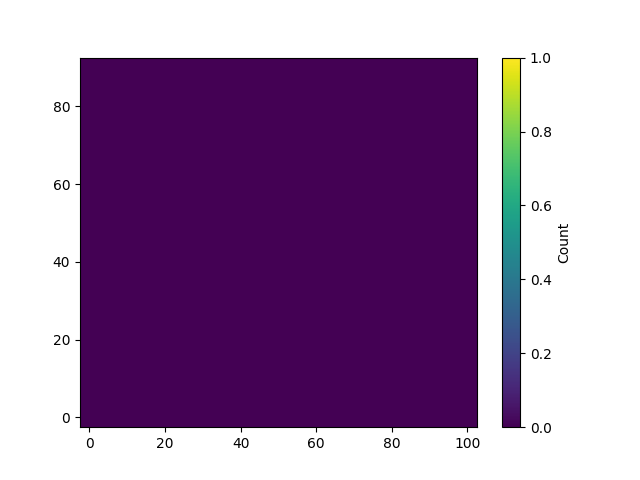

In [11]:
%matplotlib ipympl

fig, ax = plt.subplots() #matplotlib's axis and figure notation is so annoying and obtuse...

#Now we'd like to try to animate it. 
#https://matplotlib.org/stable/users/explain/animations/animations.html
#Eventually had to use ChatGPT to help here. Could not get the ArtistAnimator to work, but it could
#get the FuncAnimation to work--evidentially defining zz inside the funciton/loop was important.
#Even though I thought I already tried that...

#Now we actually need to get the slices
#Set up x and y divisions.        
xx = np.linspace(0, 100, 21)
yy = np.linspace(0, 90, 19)

#The scale value for how much color detail we want:
cmap = 'viridis'
vmin=0
vmax=1

c = ax.pcolor(xx,yy, np.zeros((Y, X)), cmap=cmap,vmin=vmin,vmax=vmax)
fig.colorbar(c, ax=ax, label='Count')
# annoyance of animation: trying to update the color bar duplicates it.
# so we need a "dummy" plot to initialize it before we start animating. 

#Making an array so the title can display the azimuth angle. 
angles = ["000", "005", "010", "015", "020", "025", "030", "035", "040", "045", "050", "055", "060", "065", "070", "075",
             "080", "085", "090", "095", "100", "105", "110", "115", "120", "125", "130", "135", "140", "145", "150", "155",
             "160", "165", "170", "175", "180"] 

def update(frame):
    ax.clear()
    zz = np.zeros((Y, X))
    for x in range(X):
        for y in range(Y):
            zz[y][x] = realBinsS[x][y][frame]
    azimuth = ax.pcolor(xx, yy, zz, cmap=cmap,vmin=vmin,vmax=vmax)
    ax.set(xlim=[-2.5,102.5], ylim=[-2.5,92.5], xlabel='Incidence Angle', ylabel='Emission Angle', 
           title = 'Viewing Angle Bin Counts. Azimuth: '+str(angles[frame])+ ' degrees')
    

ani = animation.FuncAnimation(fig, update, frames=Z, interval=500)

# To save the animation using Pillow as a gif. Use FFMpegFileWriter for mp4. 
#writer = animation.FFMpegFileWriter(fps = 2)
#ani.save('TEST2.mp4', writer = writer)
#writer = animation.PillowWriter(fps=5)
#ani.save('TEST2.gif', writer=writer)

plt.show()

In [12]:
ani.pause()
plt.close()

INTERPOLATION CODE from INTERPOLATION PROGRAM made ELSEWHERE!

In [13]:
#IMPORTS
import math
import numpy as np
import pyvista as pv

#INPUT: a 3D array. We happen to have one constructed from the above notebook, but in actual use this will be
#defined or input some other way.
inputMatrix = realBinsS
inputMatrix2 = realBinsL

#EXTRACT: Identify where the actual point values are in the matrix, and put them in an array.
pointArray = []
i,j,k = 0,0,0
for x in range(len(inputMatrix)):
    j = 0
    for y in range (len(inputMatrix[0])):
        k = 0
        for z in range (len(inputMatrix[0][0])):
            if (inputMatrix[i][j][k] != 0):
                pointArray.append([i,j,k])
            k = k+1
        j = j+1
    i = i+1

pointArray2 = []
i,j,k = 0,0,0
for x in range(len(inputMatrix2)):
    j = 0
    for y in range (len(inputMatrix2[0])):
        k = 0
        for z in range (len(inputMatrix2[0][0])):
            if (inputMatrix2[i][j][k] != 0):
                pointArray2.append([i,j,k])
            k = k+1
        j = j+1
    i = i+1

#TETRAHEDRALIZE: Divide up the points into tetrahedron cells.
mesh = pv.PolyData(pointArray).delaunay_3d() #turns points into mesh, then draws the tetrahedrons.
mesh2 = pv.PolyData(pointArray2).delaunay_3d() #turns points into mesh, then draws the tetrahedrons.

#INTERPOLATE: For every "pixel" in the matrix, find a value if possible.
#Fortunately if "not inside any cell" occurs, the method returns -1, an easy check.
finalMatrix = [[[0 for x in range(len(inputMatrix[0][0]))] for x in range(len(inputMatrix[0]))] for x in range(len(inputMatrix))]
i,j,k = 0,0,0
for x in range(len(inputMatrix)):
    j = 0
    for y in range (len(inputMatrix[0])):
        k = 0
        for z in range (len(inputMatrix[0][0])):
            if (inputMatrix[i][j][k] != 0):
                finalMatrix[i][j][k] = inputMatrix[i][j][k]
                #If we are on a point, don't bother interpolating. 
            else:
                cellNum = mesh.find_containing_cell([i,j,k])
                if (cellNum == -1):
                    finalMatrix[i][j][k] = -1
                    #Exterior Values get Zero'd
                else:
                    cell = mesh.get_cell(cellNum)
                    cellPoints = cell.points
                    #And now we can do the actual interpolation.
                    pointVals = []
                    iter = 0
                    while (iter < 4):
                        pointVals.append(inputMatrix[int(cellPoints[iter][0])][int(cellPoints[iter][1])][int(cellPoints[iter][2])])
                        iter=iter+1
                    #pointVals hold the values at all points.
                    #Now the matrix magic is below
                    M = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V = (1./6.)*np.absolute(np.linalg.det(M))
                    M1 = [[float(i),float(j),float(k),1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V1 = (1./6.)*np.absolute(np.linalg.det(M1))
                    M2 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [float(i),float(j),float(k),1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V2 = (1./6.)*np.absolute(np.linalg.det(M2))
                    M3 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [float(i),float(j),float(k),1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V3 = (1./6.)*np.absolute(np.linalg.det(M3))
                    M4 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [float(i),float(j),float(k),1.0]]
                    V4 = (1./6.)*np.absolute(np.linalg.det(M4))
                    #print(V, V1, V2, V3, V4, V1+V2+V3+V4)
                    #The volumes of each of these segments correspond to the vertex not part of their calculation.
                    #Thus we interpolate with simple divisions:
                    interpVal = pointVals[0]*(V1/V) + pointVals[1]*(V2/V) + pointVals[2]*(V3/V) + pointVals[3]*(V4/V)
                    finalMatrix[i][j][k] = float(interpVal)                    
            k = k+1
        j = j+1
    i = i+1

finalMatrix2 = [[[0 for x in range(len(inputMatrix2[0][0]))] for x in range(len(inputMatrix2[0]))] for x in range(len(inputMatrix2))]
i,j,k = 0,0,0
for x in range(len(inputMatrix2)):
    j = 0
    for y in range (len(inputMatrix2[0])):
        k = 0
        for z in range (len(inputMatrix2[0][0])):
            if (inputMatrix2[i][j][k] != 0):
                finalMatrix2[i][j][k] = inputMatrix2[i][j][k]
                #If we are on a point, don't bother interpolating. 
            else:
                cellNum = mesh2.find_containing_cell([i,j,k])
                if (cellNum == -1):
                    finalMatrix2[i][j][k] = -1
                    #Exterior Values get Negative'd
                else:
                    cell = mesh2.get_cell(cellNum)
                    cellPoints = cell.points
                    #And now we can do the actual interpolation.
                    pointVals = []
                    iter = 0
                    while (iter < 4):
                        pointVals.append(inputMatrix2[int(cellPoints[iter][0])][int(cellPoints[iter][1])][int(cellPoints[iter][2])])
                        iter=iter+1
                    #pointVals hold the values at all points.
                    #Now the matrix magic is below
                    M = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V = (1./6.)*np.absolute(np.linalg.det(M))
                    M1 = [[float(i),float(j),float(k),1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V1 = (1./6.)*np.absolute(np.linalg.det(M1))
                    M2 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [float(i),float(j),float(k),1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V2 = (1./6.)*np.absolute(np.linalg.det(M2))
                    M3 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [float(i),float(j),float(k),1.0],
                        [cellPoints[3][0],cellPoints[3][1],cellPoints[3][2],1.0]]
                    V3 = (1./6.)*np.absolute(np.linalg.det(M3))
                    M4 = [[cellPoints[0][0],cellPoints[0][1],cellPoints[0][2],1.0],
                        [cellPoints[1][0],cellPoints[1][1],cellPoints[1][2],1.0],
                        [cellPoints[2][0],cellPoints[2][1],cellPoints[2][2],1.0],
                        [float(i),float(j),float(k),1.0]]
                    V4 = (1./6.)*np.absolute(np.linalg.det(M4))
                    #print(V, V1, V2, V3, V4, V1+V2+V3+V4)
                    #The volumes of each of these segments correspond to the vertex not part of their calculation.
                    #Thus we interpolate with simple divisions:
                    interpVal = pointVals[0]*(V1/V) + pointVals[1]*(V2/V) + pointVals[2]*(V3/V) + pointVals[3]*(V4/V)
                    finalMatrix2[i][j][k] = float(interpVal)                    
            k = k+1
        j = j+1
    i = i+1
#print(finalMatrix)

C:\Users\deran\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyvista\core\utilities\points.py:55: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(


[0.03028, 0.030042, 0.031658, 0.033164, 0.035488, 0.03848, 0.043386, 0.050109, 0.057651, 0.069564, 0.084548, 0.101398, 0.121574, 0.14829, 0.183457, 0.226889, 0.27564, 0.3239, 0.363635]


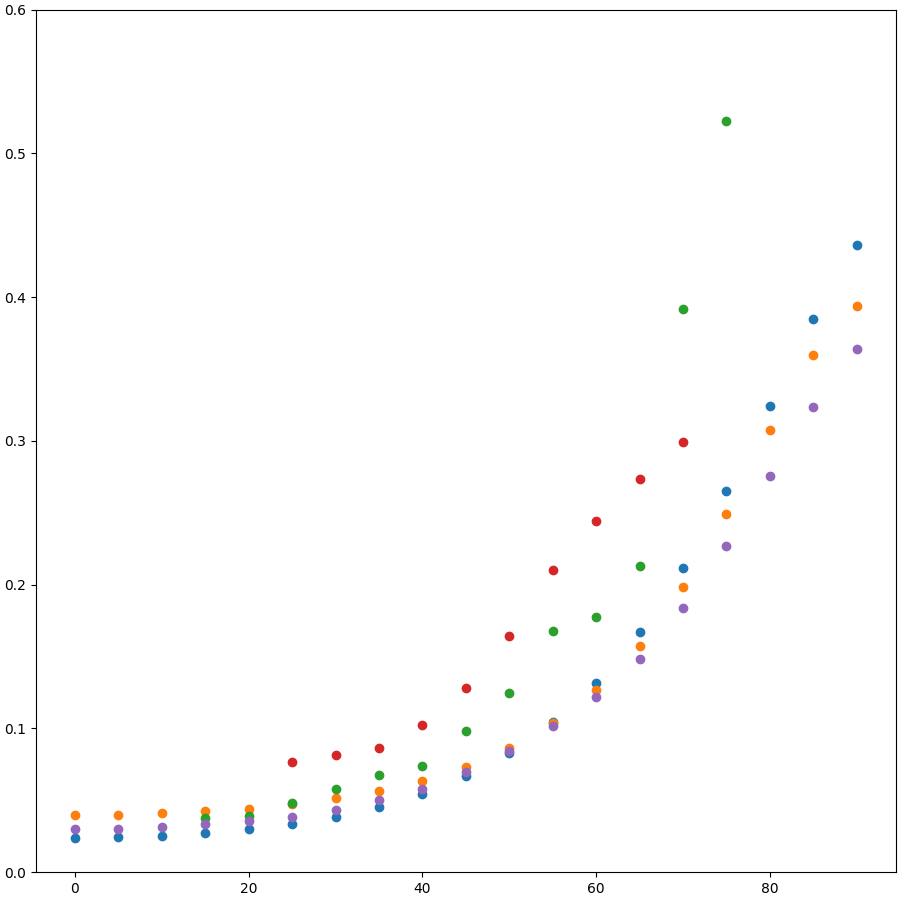

In [14]:
# CUT A LINE AND COMPARE
# This really isn't a presentation notebook anymore, huh?
# Anyway we just need to look at a particular slice. We have chosen 2um 25 azim and 65 incidence. The emission angle is the dependent variable.
# We need to plot the specular model, the lake data, and the land data. 
#(Lambertian model is probably useuless, but we can go ahead and plot it I suppose).
#Each series should have 19 data values.
specModel = []
lambModel = []
lakeData = []
landData = []
specialData = []
Eangles = []

azim = 5 #azimuth, 5=25 degrees.
inci = 13 #incidence, 13=65 degrees.

i = 0
while (i < 19):
    specModel.append(dataWin5[inci][i][azim])
    lambModel.append(dataWin5L[inci][i][azim])
    lakeData.append(finalMatrix[inci][i][azim])
    landData.append(finalMatrix2[inci][i][azim])
    specialData.append(dataWinSpecial[inci][i][azim])
    Eangles.append(i*5.)
    i=i+1

#The problem here is that these things aren't in the same scale domian, makes it hard to compare. So we need to reclaim the
#line's shape without altering anything else. The problem is our sets of data have different lengths! 
#One may think the derivative may help, but it also scales based on the actual values. But you know what doesn't? 
#Multiplicity. The number you multiply one point by to get the next, that is a scale-invariant quantity. We can use that
#To extract generic shapes. Cycle through and alter everything according to this.

fig, ax = plt.subplots(figsize = (9,9), layout="constrained") #matplotlib's axis and figure notation is so annoying and obtuse...

ax.scatter(Eangles, np.array(specModel)*8.)
ax.scatter(Eangles, np.array(lambModel)*8.)
ax.scatter(Eangles, lakeData)
ax.scatter(Eangles, landData)
ax.scatter(Eangles, np.array(specialData))

print(specialData)

ax.set(ylim = [0.0,0.6])

plt.show()

In [15]:
#Point Searcher
#Find lines in the model in all three dimensions, reports how many pixels are in the line.
#Currently only works across single dimensions, diagonal cuts will be used only if needed.

inci = 0.
azim = 0.
emis = 0.

iSize = 21
eSize = 19
aSize = 37

#run the search along all three axes.
#INCIDENCE LINES
i,j,k = 0,0,0
while (i < eSize):
    j=0
    while (j < aSize):
        k=0
        hitsS = 0
        hitsL = 0
        while (k < iSize):
            specItem = finalMatrix[k][i][j]
            lambItem = finalMatrix2[k][i][j]
            if (specItem >= 0):
                hitsS = hitsS+1 
            if (lambItem >= 0):
                hitsL = hitsL+1
            k=k+1
        if (hitsS > 5 and hitsL > 5):
            print("Inci", i*5., j*5., hitsS, hitsL)
        j=j+1
    i=i+1

#EMISSION LINES
i,j,k = 0,0,0
while (i < iSize):
    j=0
    while (j < aSize):
        k=0
        hitsS = 0
        hitsL = 0
        while (k < eSize):
            specItem = finalMatrix[i][k][j]
            lambItem = finalMatrix2[i][k][j]
            if (specItem >= 0):
                hitsS = hitsS+1 
            if (lambItem >= 0):
                hitsL = hitsL+1
            k=k+1
        if (hitsS > 10 and hitsL > 10):
            print(i*5., "Emis", j*5., hitsS, hitsL)
        j=j+1
    i=i+1

#AZIMUTH LINES
i,j,k = 0,0,0
while (i < iSize):
    j=0
    while (j < eSize):
        k=0
        hitsS = 0
        hitsL = 0
        while (k < aSize):
            specItem = finalMatrix[i][j][k]
            lambItem = finalMatrix2[i][j][k]
            if (specItem >= 0):
                hitsS = hitsS+1 
            if (lambItem >= 0):
                hitsL = hitsL+1
            k=k+1
        if (hitsS > 20 and hitsL > 20):
            print(i*5., j*5., "Azim", hitsS, hitsL)
        j=j+1
    i=i+1

Inci 55.0 45.0 6 6
Inci 55.0 50.0 6 6
Inci 55.0 55.0 6 6
Inci 55.0 60.0 6 6
Inci 60.0 5.0 7 6
Inci 60.0 10.0 7 6
Inci 60.0 15.0 7 6
Inci 60.0 20.0 6 6
Inci 60.0 50.0 6 6
Inci 60.0 55.0 6 6
Inci 60.0 60.0 6 6
Inci 60.0 65.0 6 6
Inci 60.0 70.0 6 6
Inci 60.0 75.0 6 6
Inci 60.0 80.0 6 6
Inci 60.0 85.0 6 6
Inci 65.0 5.0 7 7
Inci 65.0 10.0 7 6
Inci 65.0 15.0 7 6
Inci 65.0 20.0 7 6
Inci 65.0 25.0 6 6
Inci 65.0 30.0 6 6
Inci 65.0 35.0 6 6
Inci 65.0 40.0 6 6
Inci 65.0 45.0 6 6
Inci 65.0 50.0 6 6
Inci 65.0 55.0 6 7
Inci 65.0 60.0 6 7
Inci 65.0 65.0 6 7
Inci 65.0 70.0 6 7
Inci 65.0 75.0 6 7
Inci 65.0 80.0 6 6
Inci 65.0 85.0 6 6
Inci 65.0 90.0 6 6
Inci 65.0 95.0 6 7
Inci 65.0 100.0 6 7
Inci 65.0 105.0 6 7
Inci 65.0 110.0 6 7
Inci 70.0 20.0 7 6
Inci 70.0 25.0 7 7
Inci 70.0 30.0 7 6
Inci 70.0 125.0 6 7
Inci 70.0 130.0 6 7
Inci 70.0 135.0 6 8
65.0 Emis 35.0 13 11
65.0 Emis 40.0 13 11
65.0 Emis 45.0 11 11
65.0 Emis 50.0 11 11
65.0 Emis 55.0 11 12
65.0 Emis 60.0 11 12
65.0 Emis 65.0 11 12
70.0 Emis 55.

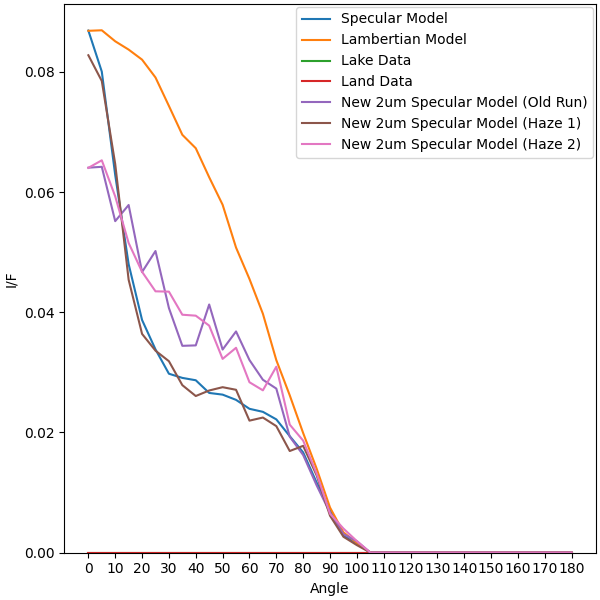

In [16]:
plt.close()
import mpl_interactions.ipyplot as iplt
fig, ax = plt.subplots(figsize = (6,6), layout="constrained") #matplotlib's axis and figure notation is so annoying and obtuse...

angleSpace = np.linspace(0, 180, 37)
inciSpace = np.linspace(0, 100, 21)
emisSpace = np.linspace(0, 90, 19)
azimSpace = np.linspace(0, 180, 37)
typeSpace = np.linspace(1,3,3)

def SM(inci,emis,azim,types):
    theLine = []
    inci =int(inci/5)
    emis =int(emis/5)
    azim =int(azim/5)
    types =int(types)

    i = 0
    if (types == 1):
        while (i < 21):
            theLine.append(dataWin5[i][emis][azim]*8)
            i=i+1
    if (types == 2):
        while (i < 19):
            theLine.append(dataWin5[inci][i][azim]*8)
            i=i+1
    if (types == 3):
        while (i < 37):
            theLine.append(dataWin5[inci][emis][i]*8)
            i=i+1

    while (i < 37):
        theLine.append(0.)
        i=i+1
    
    return theLine
def LM(inci,emis,azim,types):
    theLine = []
    inci =int(inci/5)
    emis =int(emis/5)
    azim =int(azim/5)
    types =int(types)

    i = 0
    if (types == 1):
        while (i < 21):
            theLine.append(dataWin5L[i][emis][azim]*8)
            i=i+1
    if (types == 2):
        while (i < 19):
            theLine.append(dataWin5L[inci][i][azim]*8)
            i=i+1
    if (types == 3):
        while (i < 37):
            theLine.append(dataWin5L[inci][emis][i]*8)
            i=i+1

    while (i < 37):
        theLine.append(0.)
        i=i+1
    
    return theLine
def LkD(inci,emis,azim,types):
    theLine = []
    inci =int(inci/5)
    emis =int(emis/5)
    azim =int(azim/5)
    types =int(types)

    i = 0
    if (types == 1):
        while (i < 21):
            theLine.append(finalMatrix[i][emis][azim])
            if(theLine[i] <0): theLine[i] = 0
            i=i+1
    if (types == 2):
        while (i < 19):
            theLine.append(finalMatrix[inci][i][azim])
            if(theLine[i] <0): theLine[i] = 0
            i=i+1
    if (types == 3):
        while (i < 37):
            theLine.append(finalMatrix[inci][emis][i])
            if(theLine[i] <0): theLine[i] = 0
            i=i+1

    while (i < 37):
        theLine.append(0.)
        i=i+1
    
    return theLine
def LnD(inci,emis,azim,types):
    theLine = []
    inci =int(inci/5)
    emis =int(emis/5)
    azim =int(azim/5)
    types =int(types)

    i = 0
    if (types == 1):
        while (i < 21):
            theLine.append(finalMatrix2[i][emis][azim])
            if(theLine[i] <0): theLine[i] = 0
            i=i+1
    if (types == 2):
        while (i < 19):
            theLine.append(finalMatrix2[inci][i][azim])
            if(theLine[i] <0): theLine[i] = 0
            i=i+1
    if (types == 3):
        while (i < 37):
            theLine.append(finalMatrix2[inci][emis][i])
            if(theLine[i] <0): theLine[i] = 0
            i=i+1

    while (i < 37):
        theLine.append(0.)
        i=i+1
    
    return theLine

def SpecialD(inci,emis,azim,types):
    theLine = []
    inci =int(inci/5)
    emis =int(emis/5)
    azim =int(azim/5)
    types =int(types)

    i = 0
    if (types == 1):
        while (i < 21):
            theLine.append(dataWinSpecial[i][emis][azim]) #No need to multiply by 8 as this was calculated without other wavelenghts. Yes, an original code oversight.
            i=i+1
    if (types == 2):
        while (i < 19):
            theLine.append(dataWinSpecial[inci][i][azim])
            i=i+1
    if (types == 3):
        while (i < 37):
            theLine.append(dataWinSpecial[inci][emis][i])
            i=i+1

    while (i < 37):
        theLine.append(0.)
        i=i+1
    
    return theLine

def SpecialD1(inci,emis,azim,types):
    theLine = []
    inci =int(inci/5)
    emis =int(emis/5)
    azim =int(azim/5)
    types =int(types)

    i = 0
    if (types == 1):
        while (i < 21):
            theLine.append(dataWinSpecial1[i][emis][azim]) #No need to multiply by 8 as this was calculated without other wavelenghts. Yes, an original code oversight.
            i=i+1
    if (types == 2):
        while (i < 19):
            theLine.append(dataWinSpecial1[inci][i][azim])
            i=i+1
    if (types == 3):
        while (i < 37):
            theLine.append(dataWinSpecial1[inci][emis][i])
            i=i+1

    while (i < 37):
        theLine.append(0.)
        i=i+1
    
    return theLine

def SpecialD2(inci,emis,azim,types):
    theLine = []
    inci =int(inci/5)
    emis =int(emis/5)
    azim =int(azim/5)
    types =int(types)

    i = 0
    if (types == 1):
        while (i < 21):
            theLine.append(dataWinSpecial2[i][emis][azim]) #No need to multiply by 8 as this was calculated without other wavelenghts. Yes, an original code oversight.
            i=i+1
    if (types == 2):
        while (i < 19):
            theLine.append(dataWinSpecial2[inci][i][azim])
            i=i+1
    if (types == 3):
        while (i < 37):
            theLine.append(dataWinSpecial2[inci][emis][i])
            i=i+1

    while (i < 37):
        theLine.append(0.)
        i=i+1
    
    return theLine

angleLabels = [0, 10, 20, 30, 40, 50, 60, 70,
             80, 90, 100, 110, 120, 130, 140, 150,
             160, 170, 180] 

ticker = [0,2,4,6,8,10,12,14,16,18,20,22,24,26,28,30,32,34,36]

controls = iplt.plot(SM, inci=inciSpace, emis=emisSpace, azim=azimSpace, types=typeSpace, ax = ax, label="Specular Model")
iplt.plot(LM, controls=controls, ax = ax, label="Lambertian Model")
iplt.plot(LkD, controls=controls, ax = ax, label="Lake Data")
iplt.plot(LnD, controls=controls, ax = ax, label="Land Data")
iplt.plot(SpecialD, controls=controls, ax = ax, label="New 2um Specular Model (Old Run)")
iplt.plot(SpecialD1, controls=controls, ax = ax, label="New 2um Specular Model (Haze 1)")
iplt.plot(SpecialD2, controls=controls, ax = ax, label="New 2um Specular Model (Haze 2)")
ax.set(ylim = 0.0,xlabel = "Angle", ylabel = "I/F", xticks = ticker, xticklabels = angleLabels)
fig.legend()
#plt.savefig("TitanColorSchemes.tif", format="tif", bbox_inches='tight')

plt.show()

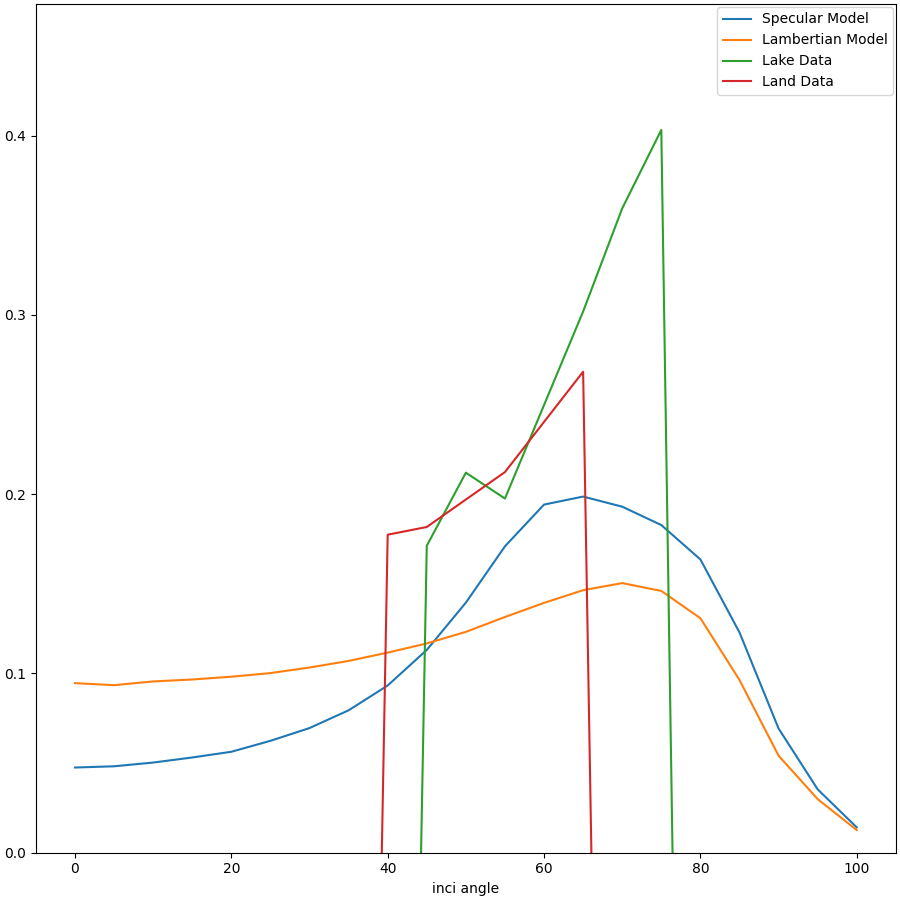

In [17]:
#55

plt.close()
# Getting a Sliced Line through the thing...
sline = "inci" # "inci" "emis" "azim"
specModel = []
lambModel = []
lakeData = []
landData = []
Eangles = []

inci = 11 #incidence, 13=65 degrees.
emis = 12 #emission, 12=60 degrees.
azim = 1 #azimuth. 
#The one being sliced through will not be used. 
#GOOD ONES: INCI 14 5
# 11 13 AZIM



i = 0
if (sline == "inci"):
    while (i < 21):
        specModel.append(dataWin5[i][emis][azim])
        lambModel.append(dataWin5L[i][emis][azim])
        lakeData.append(finalMatrix[i][emis][azim])
        landData.append(finalMatrix2[i][emis][azim])
        Eangles.append(i*5.)
        i=i+1
if (sline == "emis"):
    while (i < 19):
        specModel.append(dataWin5[inci][i][azim])
        lambModel.append(dataWin5L[inci][i][azim])
        lakeData.append(finalMatrix[inci][i][azim])
        landData.append(finalMatrix2[inci][i][azim])
        Eangles.append(i*5.)
        i=i+1
if (sline == "azim"):
    while (i < 37):
        specModel.append(dataWin5[inci][emis][i])
        lambModel.append(dataWin5L[inci][emis][i])
        lakeData.append(finalMatrix[inci][emis][i])
        landData.append(finalMatrix2[inci][emis][i])
        Eangles.append(i*5.)
        i=i+1

#The problem here is that these things aren't in the same scale domian, makes it hard to compare. So we need to reclaim the
#line's shape without altering anything else. The problem is our sets of data have different lengths! 
#One may think the derivative may help, but it also scales based on the actual values. But you know what doesn't? 
#Multiplicity. The number you multiply one point by to get the next, that is a scale-invariant quantity. We can use that
#To extract generic shapes. Cycle through and alter everything according to this.

fig, ax = plt.subplots(figsize = (9,9), layout="constrained") #matplotlib's axis and figure notation is so annoying and obtuse...

ax.plot(Eangles, np.array(specModel)*8., label="Specular Model")
ax.plot(Eangles, np.array(lambModel)*8., label="Lambertian Model")
ax.plot(Eangles, lakeData, label="Lake Data")
ax.plot(Eangles, landData, label="Land Data")
ax.set(xlabel = sline + " angle")
fig.legend()

ax.set(ylim = 0.0)

plt.show()

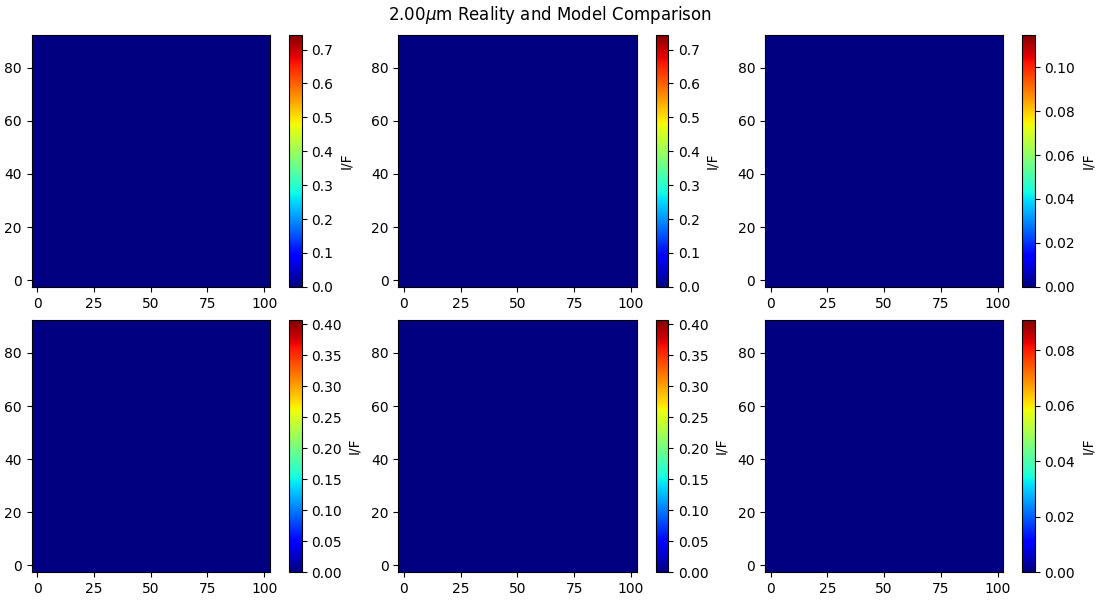

In [18]:
#DISPLAY CODE (separate, in case you just need the calculation).
%matplotlib ipympl

fig, axs = plt.subplots(2,3, figsize = (11,6), layout="constrained") #matplotlib's axis and figure notation is so annoying and obtuse...
xDim = len(finalMatrix)
yDim = len(finalMatrix[0])
zDim = len(finalMatrix[0][0])

xx = np.linspace(0, 100, 21)
yy = np.linspace(0, 90, 19)

cmap = 'jet'
vmin= 0.0
vmax1 = np.amax(inputMatrix)
vmax2 = np.amax(finalMatrix)
vmax3 = np.amax(dataWin5)
vmax4 = np.amax(inputMatrix2)
vmax5 = np.amax(finalMatrix2)
vmax6 = np.amax(dataWin5L)
c1 = axs[0][0].pcolor(xx,yy, np.zeros((Y, X)), cmap=cmap,vmin=vmin,vmax=vmax1)
fig.colorbar(c1, ax=axs[0][0], label='I/F')
c2 = axs[0][1].pcolor(xx,yy, np.zeros((Y, X)), cmap=cmap,vmin=vmin,vmax=vmax2)
fig.colorbar(c2, ax=axs[0][1], label='I/F')
c3 = axs[0][2].pcolor(xx,yy, np.zeros((Y, X)), cmap=cmap,vmin=vmin,vmax=vmax3)
fig.colorbar(c3, ax=axs[0][2], label='I/F')
c1 = axs[1][0].pcolor(xx,yy, np.zeros((Y, X)), cmap=cmap,vmin=vmin,vmax=vmax4)
fig.colorbar(c1, ax=axs[1][0], label='I/F')
c2 = axs[1][1].pcolor(xx,yy, np.zeros((Y, X)), cmap=cmap,vmin=vmin,vmax=vmax5)
fig.colorbar(c2, ax=axs[1][1], label='I/F')
c3 = axs[1][2].pcolor(xx,yy, np.zeros((Y, X)), cmap=cmap,vmin=vmin,vmax=vmax6)
fig.colorbar(c3, ax=axs[1][2], label='I/F')

fig.suptitle("2.00$\mu$m Reality and Model Comparison")

def update(frame):
    axs[0][0].clear
    axs[0][1].clear
    axs[0][2].clear
    axs[1][0].clear
    axs[1][1].clear
    axs[1][2].clear
    zz = np.zeros((yDim, xDim))
    zz2 = np.zeros((yDim, xDim)) 
    zz3 = np.zeros((yDim, xDim)) 
    zz4 = np.zeros((yDim, xDim))
    zz5 = np.zeros((yDim, xDim)) 
    zz6 = np.zeros((yDim, xDim)) 
    for x in range(xDim):
        for y in range(yDim):
            zz[y][x] = finalMatrix[x][y][frame]
            zz2[y][x] = inputMatrix[x][y][frame]
            zz3[y][x] = dataWin5[x][y][frame]
            zz4[y][x] = inputMatrix2[x][y][frame]
            zz5[y][x] = finalMatrix2[x][y][frame]
            zz6[y][x] = dataWin5L[x][y][frame]
    azimuth = axs[0][0].pcolor(xx, yy, zz2,vmin=vmin,vmax=vmax1,cmap=cmap)
    azimuth2 = axs[0][1].pcolor(xx, yy, zz,vmin=vmin,vmax=vmax2,cmap=cmap)
    azimuth3 = axs[0][2].pcolor(xx, yy, zz3,vmin=vmin,vmax=vmax3,cmap=cmap)
    azimuth = axs[1][0].pcolor(xx, yy, zz4,vmin=vmin,vmax=vmax4,cmap=cmap)
    azimuth2 = axs[1][1].pcolor(xx, yy, zz5,vmin=vmin,vmax=vmax5,cmap=cmap)
    azimuth3 = axs[1][2].pcolor(xx, yy, zz6,vmin=vmin,vmax=vmax6,cmap=cmap)
    axs[0][0].set(xlabel='Incidence Angle', ylabel='Emission Angle', 
           title = 'Sea Real; Azim: '+str(angles[frame]))
    axs[0][1].set(xlabel='Incidence Angle', ylabel='Emission Angle', 
           title = 'Sea Interp; Azim: '+str(angles[frame]))
    axs[0][2].set(xlabel='Incidence Angle', ylabel='Emission Angle', 
           title = 'Spec Model; Azim: '+str(angles[frame]))
    axs[1][0].set(xlabel='Incidence Angle', ylabel='Emission Angle', 
           title = 'Land Real; Azim: '+str(angles[frame]))
    axs[1][1].set(xlabel='Incidence Angle', ylabel='Emission Angle', 
           title = 'Land Interp; Azim: '+str(angles[frame]))
    axs[1][2].set(xlabel='Incidence Angle', ylabel='Emission Angle', 
           title = 'Lamb Model; Azim: '+str(angles[frame]))

ani2 = animation.FuncAnimation(fig, update, frames=zDim, interval=100)

#writer = animation.FFMpegFileWriter(fps = 2)
#ani2.save('200umRealityVsModel.mp4', writer=writer)

plt.show()

In [19]:
ani2.pause()
plt.close()

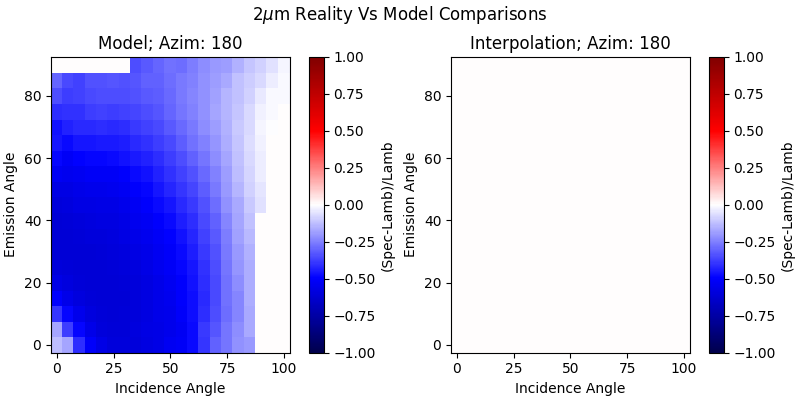

In [20]:
#Two model comparison? 

%matplotlib ipympl

realDiff = [[[0 for x in range(len(inputMatrix2[0][0]))] for x in range(len(inputMatrix2[0]))] for x in range(len(inputMatrix2))]
modelDiff = [[[0 for x in range(len(inputMatrix2[0][0]))] for x in range(len(inputMatrix2[0]))] for x in range(len(inputMatrix2))]

i,j,k = 0,0,0
for x in range(len(inputMatrix2)):
    j = 0
    for y in range (len(inputMatrix2[0])):
        k = 0
        for z in range (len(inputMatrix2[0][0])):
            if ( finalMatrix[i][j][k] > 0.001 and finalMatrix2[i][j][k] > 0.001):
                realDiff[i][j][k] = (finalMatrix[i][j][k] - finalMatrix2[i][j][k])/finalMatrix2[i][j][k]
            if ( dataWin5[i][j][k] > 0.001 and dataWin5L[i][j][k] > 0.001):
                modelDiff[i][j][k] = (dataWin5[i][j][k] - dataWin5L[i][j][k])/dataWin5L[i][j][k]
            k=k+1
        j=j+1
    i=i+1

fig, axs = plt.subplots(1,2, figsize = (8,4), layout="constrained") #matplotlib's axis and figure notation is so annoying and obtuse...
xDim = len(finalMatrix)
yDim = len(finalMatrix[0])
zDim = len(finalMatrix[0][0])

xx = np.linspace(0, 100, 21)
yy = np.linspace(0, 90, 19)

cmap = 'seismic'
vmin1= -1
vmax1 = -vmin1
vmin2 = -1
vmax2 = -vmin2

c1 = axs[0].pcolor(xx,yy, np.zeros((Y, X)), cmap=cmap,vmin=vmin1,vmax=vmax1)
fig.colorbar(c1, ax=axs[0], label='(Spec-Lamb)/Lamb')
c2 = axs[1].pcolor(xx,yy, np.zeros((Y, X)), cmap=cmap,vmin=vmin2,vmax=vmax2)
fig.colorbar(c2, ax=axs[1], label='(Spec-Lamb)/Lamb')

fig.suptitle("$2\mu$m Reality Vs Model Comparisons")

def update(frame):
    axs[0].clear
    axs[1].clear
    zz = np.zeros((yDim, xDim))
    zz2 = np.zeros((yDim, xDim)) 
    for x in range(xDim):
        for y in range(yDim):
            zz[y][x] = realDiff[x][y][frame]
            zz2[y][x] = modelDiff[x][y][frame]
    azimuth = axs[0].pcolor(xx, yy, zz2,cmap=cmap,vmin=vmin1,vmax=vmax1)
    azimuth2 = axs[1].pcolor(xx, yy, zz,cmap=cmap,vmin=vmin2,vmax=vmax2)
    axs[0].set(xlabel='Incidence Angle', ylabel='Emission Angle', 
           title = 'Model; Azim: '+str(angles[frame]))
    axs[1].set(xlabel='Incidence Angle', ylabel='Emission Angle', 
           title = 'Interpolation; Azim: '+str(angles[frame]))

ani3 = animation.FuncAnimation(fig, update, frames=zDim, interval=100)

writer = animation.FFMpegFileWriter(fps = 2)
ani3.save('200umRealityVsModelRelative.mp4', writer=writer)

plt.show()

In [21]:
ani3.pause()
plt.close()

## Analysis: Qualitative

### Does the Cube Match?

#### We'll do the Quantitative later. Surely. 

So the model has its data sorted by observation geometry: specifically incidence, emission, and azimuth angle. We can easily extract these three angles from any VIMS cube. So let's extract them, use them to construct an image of the global methane ocean, and see what we get. 

I originally intended for the initial figure to be unscaled, but the simulation images are significantly dimmer than the images we're working with (at least in testing) so we have to scale things 

This initial figure will be unscaled, but it's pretty clear we're going to need some kind of scaling algorithm to make thigns line up, "highest brightest" isn't gonna cut it. 

We will also do the same for the lambertian simulation, see what we get. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.08768839285714286..1.7286991071428572].


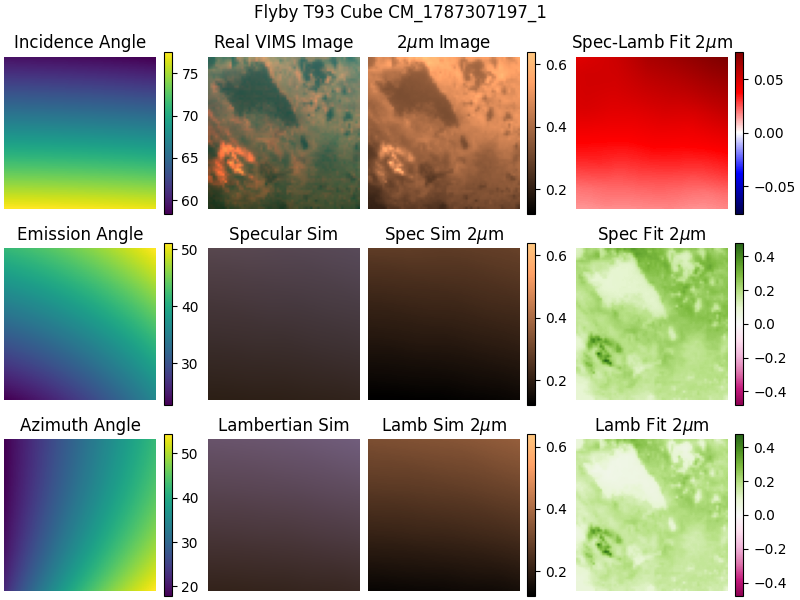

In [22]:
%matplotlib ipympl

#METADATA 
#Same arrangement as above, but examinming the metadata instead.

#DISPLAY: CUBE
#Just to show the cube we are reading in.
fig, axs = plt.subplots(3,4, figsize = (8,6), layout = "constrained") 

#Windows are, according to lambertian_wholedisk:
#0.933078, 1.08183, 1.27813, 1.59018, 2.01781, 2.69620, 2.79889, 5.00576

incidenceData = np.transpose(np.transpose(geoIRData)[5])
c1 = axs[0,0].imshow(np.transpose(geoIRData)[5], cmap="viridis")
fig.colorbar(c1, ax=axs[0][0])
emissionData = np.transpose(np.transpose(geoIRData)[6])
c2 = axs[1,0].imshow(np.transpose(geoIRData)[6], cmap="viridis")
fig.colorbar(c2, ax=axs[1][0])

#Azimuth is dealt with differently when using Jcube and PyVIMS
azimuthData = 180 - np.transpose(np.transpose(geoIRData)[7])
if (cubeFilePath != realCube):
    i,j = 0,0
    while (i < len(xAxisCube)):
        j = 0
        while (j < len(yAxisCube)):
            p = geoIRData[i][j][4] #used to calculate azimuth.
            inci = geoIRData[i][j][5]
            emis = geoIRData[i][j][6]
            ratio = -(np.cos(np.radians(p)) - np.cos(np.radians(inci))* np.cos(np.radians(emis)))/(np.sin(np.radians(inci))*np.sin(np.radians(emis)))
            azim = np.arccos(ratio) 
            #Of course, this might be nan-ing. All the nans need their own values.
            if((math.isnan(azim) == True) and (ratio>0.)):
                azim = 0.
            elif((math.isnan(azim) == True) and (ratio<0.)):
                azim = 0.
            elif((inci==0) and (emis==0)):
                azim = 0.
            elif(math.isnan(azim) == True):
                print("Well you broke it, great. (Azimuth is nan, but could not be set to anything else.)")
            azimuthData[i][j] = math.degrees(azim)
            j = j+1
        i = i+1   

    #Of course, this might be nan-ing. All the nans need their own values.
    if((math.isnan(azim) == True) and (ratio>0.)):
        azim = 0.
    elif((math.isnan(azim) == True) and (ratio<0.)):
        azim = 0.
    elif((inci==0) and (emis==0)):
        azim = 0.
    elif(math.isnan(azim) == True):
        print("Well you broke it, great. (Azimuth is nan, but could not be set to anything else.)")
    
c3 = axs[2,0].imshow(np.transpose(azimuthData), cmap="viridis")
fig.colorbar(c3, ax=axs[2][0])

image = axs[0,1].imshow(colorData,origin="upper") 
#The rotation is undone here using rotate(). 

#Okay, now comes the somewhat complicated part. We have all the data we might need, 
#we just need to pull out the values for the windows for each viewing geometry. 

specSimData = [incidenceData*0 for x in range(8)]
lambSimData = [incidenceData*0 for x in range(8)]
#These arrays contain one "image" for each wavelength. We just need to read the data in. 

geomWindows = [0.,0.,0.,0.,0.,0.,0.,0.]
geomWindowsL = [0.,0.,0.,0.,0.,0.,0.,0.]

#Define the interpolation function
def interp3D(inci, emis, azim, dataset):
    # https://en.wikipedia.org/wiki/Trilinear_interpolation
    #3D trilinear interpolation to find the value at the given point.
    #Prework: handle edge cases by makuing sure they aren't *on* the edge. 
    if (inci == 100): 
        inci = 99.9
    if (emis == 90):
        emis = 89.9
    if (azim == 180):
        azim = 179.9
    #TEMPORARY MEASURE, make the interpolation adaptable to the edge later.
    
    #First, convert the angles into "index" language. 
    inci = inci/5
    emis = emis/5
    azim = azim/5
    #Converting these to int rounds down. We need the down and up, so add 1.
    #The points we need are at all four corners. 
    c000 = dataset[int(inci)][int(emis)][int(azim)]
    c001 = dataset[int(inci)][int(emis)][int(azim)+1]
    c010 = dataset[int(inci)][int(emis)+1][int(azim)]
    c011 = dataset[int(inci)][int(emis)+1][int(azim)+1]
    c100 = dataset[int(inci)+1][int(emis)][int(azim)]
    c101 = dataset[int(inci)+1][int(emis)][int(azim)+1]
    c110 = dataset[int(inci)+1][int(emis)+1][int(azim)]
    c111 = dataset[int(inci)+1][int(emis)+1][int(azim)+1]
    #Now we have all the values, we just have to do THE MATH.
    #First, calcluate the fraction we are along the path. 
    #Since we are in cells of size 1, this is simple.
    xd = inci - int(inci)
    yd = emis - int(emis)
    zd = azim - int(azim)
    #Further calcluations 
    c00 = c000*(1.-xd) + c100*xd
    c01 = c001*(1.-xd) + c101*xd
    c10 = c010*(1.-xd) + c110*xd
    c11 = c011*(1.-xd) + c111*xd
    #Even further...
    c0 = c00*(1.-yd) + c10*yd
    c1 = c01*(1.-yd) + c11*yd
    #and the final result!
    
    return c0*(1-zd)+c1*zd

i = 0
while(i<len(incidenceData)):
    j = 0
    while (j<len(incidenceData[0])):
        
        inci = incidenceData[i][j]
        emis = emissionData[i][j]
        azim = azimuthData[i][j]
        
        if (inci > 100):
            inci = 100
        if (emis > 90):
            emis = 90
        
        #These are multiplied by 8 since the model was created off by a factor of 8. May fix if
        #I make a new model.
        specSimData[0][i][j] = interp3D(inci, emis, azim, dataWin1)*8.
        lambSimData[0][i][j] = interp3D(inci, emis, azim, dataWin1L)*8.
        
        specSimData[1][i][j] = interp3D(inci, emis, azim, dataWin2)*8.
        lambSimData[1][i][j] = interp3D(inci, emis, azim, dataWin2L)*8.
        
        specSimData[2][i][j] = interp3D(inci, emis, azim, dataWin3)*8.
        lambSimData[2][i][j] = interp3D(inci, emis, azim, dataWin3L)*8.
        
        specSimData[3][i][j] = interp3D(inci, emis, azim, dataWin4)*8.
        lambSimData[3][i][j] = interp3D(inci, emis, azim, dataWin4L)*8.
        
        specSimData[4][i][j] = interp3D(inci, emis, azim, dataWin5)*8.
        lambSimData[4][i][j] = interp3D(inci, emis, azim, dataWin5L)*8.
        
        specSimData[5][i][j] = interp3D(inci, emis, azim, dataWin6)*8.
        lambSimData[5][i][j] = interp3D(inci, emis, azim, dataWin6L)*8.
        
        specSimData[6][i][j] = interp3D(inci, emis, azim, dataWin7)*8.
        lambSimData[6][i][j] = interp3D(inci, emis, azim, dataWin7L)*8.
    
        specSimData[7][i][j] = interp3D(inci, emis, azim, dataWin8)*8.
        lambSimData[7][i][j] = interp3D(inci, emis, azim, dataWin8L)*8.
        #The 8 is there so the scaling for titancolor2 works properly.
        
        j=j+1
    i = i+1

#As we now have the data, we need to construct the images. 
#COLOR

# set R, G, and B

R2 = specSimData[7]/(mod*1.12/16.) #Average dealing shenanigans.
G2 = specSimData[4]/(mod*0.22)
B2 = (specSimData[2]-0.03)/(mod*0.37) 

R3 = lambSimData[7]/(mod*1.12/16.) #Average dealing shenanigans.
G3 = lambSimData[4]/(mod*0.22)
B3 = (lambSimData[2]-0.03)/(mod*0.37) 

#B's value can introduce negatives, remove them.
i,j = 0,0
for x in B2:
    j=0
    for y in x:
        if (y < 0):
            B2[i][j] = 0
        j = j+1
    i = i+1
i=0
j=0
for x in B3:
    j=0
    for y in x:
        if (y < 0):
            B3[i][j] = 0
        j = j+1
    i = i+1
    
# Now we need to combine them in the correct form: xyc, that is, x, y, then color value. 
colorData2 = [np.transpose(R2),np.transpose(G2),np.transpose(B2)] # arranged in cyx.
colorData2 = np.transpose(colorData2) #arranged in xyc
#This also introduces a rotation of the image by -90 degrees. 
imageS = axs[1,1].imshow(ndimage.rotate(np.array(colorData2),90),origin="lower") 
#The rotation is undone here using rotate(). 

colorData3 = [np.transpose(R3),np.transpose(G3),np.transpose(B3)] # arranged in cyx.
colorData3 = np.transpose(colorData3) #arranged in xyc
#This also introduces a rotation of the image by -90 degrees. 
imageL = axs[2,1].imshow(ndimage.rotate(np.array(colorData3),90),origin="lower") 
#The rotation is undone here using rotate(). 

maximum = np.amax((np.transpose(temp[windowInd[4]]))/(mod*0.22))
if (maximum < np.amax(np.array(G2))):
    maximum = np.amax(np.array(G2))
if (maximum < np.amax(np.array(G3))):
    maximum = np.amax(np.array(G3))
minimum = np.amin((np.transpose(temp[windowInd[4]]))/(mod*0.22))
if (minimum > np.amin(np.array(G2))):
    minimum = np.amin(np.array(G2))
if (minimum > np.amin(np.array(G3))):
    minimum = np.amin(np.array(G3))
window2um = axs[0,2].imshow((temp[windowInd[4]])/(mod*0.22), cmap="copper",vmax=maximum,vmin=minimum)
imageS2 = axs[1,2].imshow(ndimage.rotate(np.array(G2),90),origin="lower",cmap="copper",vmax=maximum,vmin=minimum) 
imageL2 = axs[2,2].imshow(ndimage.rotate(np.array(G3),90),origin="lower",cmap="copper",vmax=maximum,vmin=minimum) 

#And now the "fits" which are just subtractions.
specImg = (temp[windowInd[4]])/(mod*0.22) - ndimage.rotate(np.transpose(np.array(G2)),0)
lambImg = (temp[windowInd[4]])/(mod*0.22) - ndimage.rotate(np.transpose(np.array(G3)),0)

if (np.amax(specImg) > np.amax(lambImg)):
    maximum = np.amax(specImg)
else:
    maximum = np.amax(lambImg)
if (np.amin(specImg) < np.amin(lambImg)):
    minimum = np.amin(specImg)
else:
    minimum = np.amin(lambImg)
if (maximum < -minimum):
    maximum = -minimum #if the lower bound is larger in magnitude.

Sfit = axs[1,3].imshow(specImg,origin="upper",cmap="PiYG",vmax=maximum,vmin=-maximum) 
Lfit = axs[2,3].imshow(lambImg,origin="upper",cmap="PiYG",vmax=maximum,vmin=-maximum) 

maximum = np.amax(np.absolute(specImg)-np.absolute(lambImg))
minimum = np.amin(np.absolute(specImg)-np.absolute(lambImg))
if (maximum < -minimum):
    maximum = -minimum #if the lower bound is larger in magnitude.
SmL = axs[0,3].imshow(np.absolute(specImg)-np.absolute(lambImg),origin="upper", cmap="seismic",vmax=maximum, vmin=-maximum)

fig.colorbar(window2um, ax=axs[0][2])
fig.colorbar(imageS2, ax=axs[1][2])
fig.colorbar(imageL2, ax=axs[2][2])

fig.colorbar(Sfit, ax=axs[1][3])
fig.colorbar(Lfit, ax=axs[2][3])

fig.colorbar(SmL, ax=axs[0][3])


axs[0,0].axis('off')
axs[0,1].axis('off')
axs[1,0].axis('off')
axs[1,1].axis('off')
axs[2,0].axis('off')
axs[2,1].axis('off')

axs[0,2].axis('off')
axs[0,3].axis('off')
axs[1,2].axis('off')
axs[1,3].axis('off')
axs[2,2].axis('off')
axs[2,3].axis('off')

axs[0,0].set(title="Incidence Angle")
axs[1,0].set(title="Emission Angle")
axs[2,0].set(title="Azimuth Angle")
axs[0,1].set(title="Real VIMS Image")
axs[1,1].set(title="Specular Sim")
axs[2,1].set(title="Lambertian Sim")

axs[0,2].set(title="2$\mu$m Image")
axs[1,2].set(title="Spec Sim 2$\mu$m")
axs[2,2].set(title="Lamb Sim 2$\mu$m")
axs[0,3].set(title="Spec-Lamb Fit 2$\mu$m")
axs[1,3].set(title="Spec Fit 2$\mu$m")
axs[2,3].set(title="Lamb Fit 2$\mu$m")

fig.suptitle('Flyby ' + str(flybyNum) + " Cube " + str(cubeNum))

plt.savefig(str(flybyNum) + "_" + str(cubeNum) + "SModeled.pdf", format="pdf")

plt.show()